# Multivariate Timeseries Forecasting of Dengue Cases  

# Initial Data Examination and Preliminary Cleaning - Univariate Focus

## Data Origins and General Description  

The data was obtained from Driven Data:  

https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/  

It is comprised of timestamped environmental measurements suspected to have bearing on confirmed dengue cases in two cities:  San Juan, Puerto Rico and Iquitos, Peru.  The labels - number of dengue cases, also timestamped - are also provided for supervised learning approaches.  

The features are as listed:  

##### City and date indicators 
* city – City abbreviations: sj for San Juan and iq for Iquitos  
*  week_start_date – Date given in yyyy-mm-dd format  

##### NOAA's GHCN daily climate data weather station measurements  
* station_max_temp_c – Maximum temperature  
* station_min_temp_c – Minimum temperature  
* station_avg_temp_c – Average temperature  
* station_precip_mm – Total precipitation  
* station_diur_temp_rng_c – Diurnal temperature range  

For further reading:  https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily

##### PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)  
* precipitation_amt_mm – Total precipitation   

##### NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)  
* reanalysis_sat_precip_amt_mm – Total precipitation  
* reanalysis_dew_point_temp_k – Mean dew point temperature  
* reanalysis_air_temp_k – Mean air temperature  
* reanalysis_relative_humidity_percent – Mean relative humidity  
* reanalysis_specific_humidity_g_per_kg – Mean specific humidity  
* reanalysis_precip_amt_kg_per_m2 – Total precipitation  
* reanalysis_max_air_temp_k – Maximum air temperature  
* reanalysis_min_air_temp_k – Minimum air temperature  
* reanalysis_avg_temp_k – Average air temperature  
* reanalysis_tdtr_k – Diurnal temperature range  

For further reading:  https://www.nccs.nasa.gov/services/data-collections/coupled-products/cfsr#:~:text=The%20National%20Oceanic%20and%20Atmospheric,period%20(1979%2D2009).

##### Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements  
* ndvi_se – Pixel southeast of city centroid  
* ndvi_sw – Pixel southwest of city centroid  
* ndvi_ne – Pixel northeast of city centroid  
* ndvi_nw – Pixel northwest of city centroid  

For an explanation of NDVI:  
Wikipedia:  "It has a high correlation with the true state of vegetation on the ground. The index is easy to interpret: NDVI will be a value between -1 and 1. An area with nothing growing in it will have an NDVI of zero. NDVI will increase in proportion to vegetation growth. An area with dense, healthy vegetation will have an NDVI of one. NDVI values less than 0 suggest a lack of dry land. An ocean will yield an NDVI of -1."  
https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index, accessed Feb 2 2024

## Data: Behavioural Characteristics Driving the Analysis

When the timestamped dengue cases are examined on their own, the process is a univariate timeseries forecasting exercise.  This only examines how previous dengue cases impact feature dengue cases to help identify if the output or dependent variable is autocorrelated.  To do this an autoregression (regressing against the same variable) is performed.

When the environmental measurements are included, it becomes a multivariate forecasting exercise.  In these scenarios, not only is autocorrelation of the dependent or predicted variable examined, but its correlation to the features, or time-lagged features, is also examined.  This is to establish whether a causal relationship between the features and predicted variable exists, and over what time lag.  There exists many model frameworks to enable this sort of analysis.

This notebook contains the steps to import the data, examine basic plots of the data and get a general description of its characteristics, then gather more details around the data's temporal characteristics with the use of lag-plots and autocorrelations.

## Import and Overview of Data Quality  

The data are supplied as a set of training features, which is comprised of the environmental measurements, and training labels, which is simply the number of known dengue cases for each corresponding date.  The data is examined for its overall general characteristics like data type, mean, range, and for any anomalies as well as missing or duplicated data.

In [104]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 
#import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import concat


In [105]:
# setting up the file path structure
data_folder = os.path.join(os.pardir, 'data')
files_in_data = os.listdir(data_folder)
print(files_in_data)

['dengue_features_test.csv', 'dengue_features_train.csv', 'dengue_labels_train.csv']


# ?  

Not sure why we're bothering with multiindex  
Causes trouble later when checking for the huge time interval (city change in the rows).  And just about everything else, in particular come time to use AR, plot predictions vs test, etc.  I should've ignored the template notebook by Driven Data.  A different approach will be taken to create a eda_multivariate notebook which will take up some of the work below again (histplots, timeseries), but also add in some correlation work for the features and target.  The data import will be different.

The data provided by Driven Data for this practice competition does not include the test set's labels, which means model evaluations cannot be completed to satisfaction.  Performance on test data, including the test labels (actual target values) allows the model developer to determine if the models can produce acceptable predictions on unseen data.  

This will be addressed by treating the df_features and df_labels as though they were an entire un-split dataset, and they will later be split into a training and test set to allow for the model performance metrics to be calculated.  

The variables are named below as though they were not strictly training data.  

In [106]:
# setting index_col sets up a multi-level index
file_path1 = os.path.join(data_folder, 'dengue_features_train.csv')
df_features = pd.read_csv(file_path1, index_col=[0,1,2])

file_path2 = os.path.join(data_folder, 'dengue_labels_train.csv')
df_labels = pd.read_csv(file_path2, index_col=[0,1,2])

Let's get a sense of the size of the dataset.

In [107]:
print(df_features.shape)
print(df_labels.shape)

(1456, 21)
(1456, 1)


In [108]:
df_features.head()

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
city year weekofyear                                                           
sj   1990 18              1990-04-30  0.122600  0.103725  0.198483  0.177617   
          19              1990-05-07  0.169900  0.142175  0.162357  0.155486   
          20              1990-05-14  0.032250  0.172967  0.157200  0.170843   
          21              1990-05-21  0.128633  0.245067  0.227557  0.235886   
          22              1990-05-28  0.196200  0.262200  0.251200  0.247340   

                      precipitation_amt_mm  reanalysis_air_temp_k  \
city year weekofyear                                                
sj   1990 18                         12.42             297.572857   
          19                         22.82             298.211429   
          20                         34.54             298.781429   
          21                         15.36             298.987143   
          22                          7.52             299.518571   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
city year weekofyear                                                       
sj   1990 18                     297.742857                   292.414286   
          19                     298.442857                   293.951429   
          20                     298.878571                   295.434286   
          21                     299.228571                   295.310000   
          22                     299.664286                   295.821429   

                      reanalysis_max_air_temp_k  ...  \
city year weekofyear                             ...   
sj   1990 18                              299.8  ...   
          19                              300.9  ...   
          20                              300.5  ...   
          21                              301.4  ...   
          22                              301.9  ...   

                      reanalysis_precip_amt_kg_per_m2  \
city year weekofyear                                    
sj   1990 18                                    32.00   
          19                                    17.94   
          20                                    26.10   
          21                                    13.90   
          22                                    12.20   

                      reanalysis_relative_humidity_percent  \
city year weekofyear                                         
sj   1990 18                                     73.365714   
          19                                     77.368571   
          20                                     82.052857   
          21                                     80.337143   
          22                                     80.460000   

                      reanalysis_sat_precip_amt_mm  \
city year weekofyear                                 
sj   1990 18                                 12.42   
          19                                 22.82   
          20                                 34.54   
          21                                 15.36   
          22                                  7.52   

                      reanalysis_specific_humidity_g_per_kg  \
city year weekofyear                                          
sj   1990 18                                      14.012857   
          19                                      15.372857   
          20                                      16.848571   
          21                                      16.672857   
          22                                      17.210000   

                      reanalysis_tdtr_k  station_avg_temp_c  \
city year weekofyear                                          
sj   1990 18                   2.628571           25.442857   
          19                   2.371429           26.714286   
          20                   2.300000           26.714286   
          21                   2.428571           27.471429   
          22    

In [109]:
df_labels.head()

total_cases
city year weekofyear             
sj   1990 18                    4
          19                    5
          20                    4
          21                    3
          22                    6

Below are some quick statistics on each features, and below that, the statistics on the total cases we're aiming to predict.  
Range on the features can help indicate if some min-max scaling might be required.  The difference in magnitudes seen below indicate this will be required.

In [110]:
df_features.describe()

ndvi_ne      ndvi_nw      ndvi_se      ndvi_sw  \
count  1262.000000  1404.000000  1434.000000  1434.000000   
mean      0.142294     0.130553     0.203783     0.202305   
std       0.140531     0.119999     0.073860     0.083903   
min      -0.406250    -0.456100    -0.015533    -0.063457   
25%       0.044950     0.049217     0.155087     0.144209   
50%       0.128817     0.121429     0.196050     0.189450   
75%       0.248483     0.216600     0.248846     0.246982   
max       0.508357     0.454429     0.538314     0.546017   

       precipitation_amt_mm  reanalysis_air_temp_k  reanalysis_avg_temp_k  \
count           1443.000000            1446.000000            1446.000000   
mean              45.760388             298.701852             299.225578   
std               43.715537               1.362420               1.261715   
min                0.000000             294.635714             294.892857   
25%                9.800000             297.658929             298.257143   
50%               38.340000             298.646429             299.289286   
75%               70.235000             299.833571             300.207143   
max              390.600000             302.200000             302.928571   

       reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
count                  1446.000000                1446.000000   
mean                    295.246356                 303.427109   
std                       1.527810                   3.234601   
min                     289.642857                 297.800000   
25%                     294.118929                 301.000000   
50%                     295.640714                 302.400000   
75%                     296.460000                 305.500000   
max                     298.450000                 314.000000   

       reanalysis_min_air_temp_k  reanalysis_precip_amt_kg_per_m2  \
count                1446.000000                      1446.000000   
mean                  295.719156                        40.151819   
std                     2.565364                        43.434399   
min                   286.900000                         0.000000   
25%                   293.900000                        13.055000   
50%                   296.200000                        27.245000   
75%                   297.900000                        52.200000   
max                   299.900000                       570.500000   

       reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  \
count                           1446.000000                   1443.000000   
mean                              82.161959                     45.760388   
std                                7.153897                     43.715537   
min                               57.787143                      0.000000   
25%                               77.177143                      9.800000   
50%                               80.301429                     38.340000   
75%                               86.357857                     70.235000   
max                               98.610000                    390.600000   

       reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
count                            1446.000000        1446.000000   
mean                               16.746427           4.903754   
std                                 1.542494           3.546445   
min                                11.715714           1.357143   
25%                                15.557143           2.328571   
50%                                17.087143           2.857143   
75%                                17.978214           7.625000   
max                                20.461429          16.028571   

       station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
count         1413.000000              1413.000000         1436.000000   
mean            27.185783                 8.059328           32.452437   
std              1.292347              

In [111]:
df_labels.describe()

total_cases
count  1456.000000
mean     24.675137
std      43.596000
min       0.000000
25%       5.000000
50%      12.000000
75%      28.000000
max     461.000000

`.info()` gives a quick idea of the datatypes, but also overall "type of information" gathered.  This dataset is entirely numerical except for the week_start_date column, which is likely string given the ojbect datatype.  Manipulations on week_start_date will require turning this into a datetime.

In [112]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1456 entries, ('sj', 1990, 18) to ('iq', 2010, 25)
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   week_start_date                        1456 non-null   object 
 1   ndvi_ne                                1262 non-null   float64
 2   ndvi_nw                                1404 non-null   float64
 3   ndvi_se                                1434 non-null   float64
 4   ndvi_sw                                1434 non-null   float64
 5   precipitation_amt_mm                   1443 non-null   float64
 6   reanalysis_air_temp_k                  1446 non-null   float64
 7   reanalysis_avg_temp_k                  1446 non-null   float64
 8   reanalysis_dew_point_temp_k            1446 non-null   float64
 9   reanalysis_max_air_temp_k              1446 non-null   float64
 10  reanalysis_min_air_temp_k              1446 n

The dengue case count is naturally an integer datatype.

In [113]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1456 entries, ('sj', 1990, 18) to ('iq', 2010, 25)
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   total_cases  1456 non-null   int64
dtypes: int64(1)
memory usage: 19.1+ KB


Ensure that the time interval between rows is constant, eg. one week.  If not, rows either have to be dropped or data imputed (interpolated) to maintain a constant time interval.

In [114]:
df_features['week_start_date'] = pd.to_datetime(df_features['week_start_date'])

# Calculate the time difference between consecutive rows
df_features['time_interval'] = df_features['week_start_date'].diff()

# Check if the time interval is constant or changing
is_constant_interval = df_features['time_interval'].nunique() == 1

if is_constant_interval:
    constant_interval = df_features['time_interval'].iloc[0]
    print(f'Time interval is constant: {constant_interval}')
else:
    print('Time interval is changing.')
    unique_intervals = df_features['time_interval'].unique()
    print(f'Unique time intervals: {unique_intervals}')

    # Value counts for each unique time interval
    interval_counts = df_features['time_interval'].value_counts()
    print('Time interval value counts:')
    print(interval_counts)

# Optional: Print the DataFrame with the new 'time_interval' column
#df_features.head()


Time interval is changing.
Unique time intervals: <TimedeltaArray>
[NaT, '7 days', '8 days', '9 days', '-2852 days']
Length: 5, dtype: timedelta64[ns]
Time interval value counts:
time_interval
7 days        1426
8 days          21
9 days           7
-2852 days       1
Name: count, dtype: int64


Most intervals are 7 days, with only a few at 8 and 9 days.  For the purposes of modelling timeseries data, and given we're likely looking at time lags of weeks, not days, this variation in time interval will be considered to have negligible impact.

The interval of -2852 days is likely when the rows of data change from one city to the other.  Let's check.

Turns out a multi-index is a special pain.

In [115]:
df_features[df_features['time_interval']=='-2852 days']

week_start_date   ndvi_ne   ndvi_nw   ndvi_se  ndvi_sw  \
city year weekofyear                                                          
iq   2000 26              2000-07-01  0.192886  0.132257  0.340886   0.2472   

                      precipitation_amt_mm  reanalysis_air_temp_k  \
city year weekofyear                                                
iq   2000 26                         25.41                 296.74   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
city year weekofyear                                                       
iq   2000 26                         298.45                   295.184286   

                      reanalysis_max_air_temp_k  ...  \
city year weekofyear                             ...   
iq   2000 26                              307.3  ...   

                      reanalysis_relative_humidity_percent  \
city year weekofyear                                         
iq   2000 26                                     92.418571   

                      reanalysis_sat_precip_amt_mm  \
city year weekofyear                                 
iq   2000 26                                 25.41   

                      reanalysis_specific_humidity_g_per_kg  \
city year weekofyear                                          
iq   2000 26                                      16.651429   

                      reanalysis_tdtr_k  station_avg_temp_c  \
city year weekofyear                                          
iq   2000 26                   8.928571                26.4   

                      station_diur_temp_rng_c  station_max_temp_c  \
city year weekofyear                                                
iq   2000 26                           10.775                32.5   

                      station_min_temp_c  station_precip_mm  time_interval  
city year weekofyear                                                        
iq   2000 26                        20.7                3.0     -2852 days  

[1 rows x 22 columns]

In [116]:
desired_value = '-2852 days'
row_indices = df_features.index[df_features['time_interval'] == desired_value].tolist()

print("Row Indices:", row_indices)

Row Indices: [('iq', 2000, 26)]


In [117]:
# Specify the row you are interested in
desired_row = ('iq', 2000, 26)

# Find the numeric index of the specified row
row_index = df_features.index.get_loc(desired_row)

# Get the preceding row using iloc
preceding_row_index = row_index - 1
preceding_row = df_features.iloc[preceding_row_index]

# Get the multi-index values of the preceding row
preceding_row_values = preceding_row.name

print("Multi-Index Values of the Preceding Row:", preceding_row_values)

Multi-Index Values of the Preceding Row: ('sj', 2008, 17)


The city code changes from iq to sj when the large negative time interval occurs.  This confirms that the enormous negative interval is simply the switch of cities in the data.   

Let's investigate for nulls (NaN) and duplicates.

In [118]:
df_features.duplicated().sum()

1

In [119]:
df_features.isnull().sum()

week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_min_temp_c                        14
station_precip_mm                         22
time_interval                              1
dtype: int

In [120]:
df_labels.isnull().sum()

total_cases    0
dtype: int64

There are no duplicates in the features.  

### Imputation 

There are no nulls in the training labels, but there are varying amounts of nulls in the features.  For now those missing values will simply be imputed using the last value recorded, but there is room here for more sophisticated approaches.

Also consider checking if the nulls occur more in the one city's data or the other, or if they're spread somewhat evenly.

In [121]:
df_features.fillna(method='ffill', inplace=True)

C:\Users\ron_d\AppData\Local\Temp\ipykernel_17920\3033851633.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_features.fillna(method='ffill', inplace=True)


### Pseudo-Redundant Features  

Before splitting the data by city and embarking on examining the timeseries plots on the features, some 'pseudo-redundant' features will be removed for conciseness.  We would otherwise end up with an enormous number of plots and later, a very large number of correlations to examine.  This is not an exhaustive analysis of the features that present the most useful information for feature selection - either on their own nor as measured against the target for preditive purposes - it is a simple measure taken to reduce the number of features that are very similar to each other.  This allows for a quick progression to confirm a basic model can be generated.  This crude "feature cull" can be revisited later.

In [122]:
temp_columns = df_features.filter(like='temp')
precip_columns = df_features.filter(like='precip')
print(temp_columns.columns)
print(precip_columns.columns)

Index(['reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'station_avg_temp_c',
       'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c'],
      dtype='object')
Index(['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_sat_precip_amt_mm', 'station_precip_mm'],
      dtype='object')


Note:  the "reeanalysis" diurnal temperature range is missed in this check as one does not contain "temp" in its feature name.  This was caught and added to the work below.

May have to tease these apart a bit before plotting them to check for overlap.  Comparing an average temperature to a minimum isn't helfpul as they're not expected to be the same. The celsius temperatures would also have to be converted to Kelvin in order to compare properly.

Caution:  The station_diur_temp_rng_c should NOT go through any conversion as this is a temperature *difference*.

In [123]:
df_features['station_avg_temp_K_conv'] = df_features['station_avg_temp_c'] + 273.15
df_features['station_min_temp_K_conv'] = df_features['station_min_temp_c'] + 273.15
df_features['station_max_temp_K_conv'] = df_features['station_max_temp_c'] + 273.15

In [124]:
air_temp = ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'station_avg_temp_K_conv']
min_temp = ['reanalysis_min_air_temp_k', 'station_min_temp_K_conv']
max_temp = ['reanalysis_max_air_temp_k', 'station_max_temp_K_conv']
diurn_rg_temp = ['reanalysis_tdtr_k', 'station_diur_temp_rng_c']
precip_amt = ['precipitation_amt_mm', 'reanalysis_sat_precip_amt_mm', 'station_precip_mm']

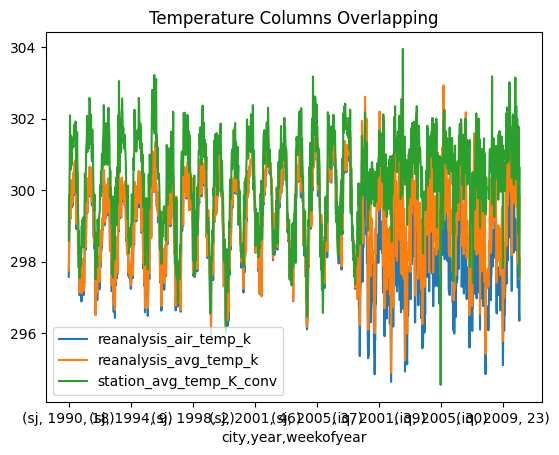

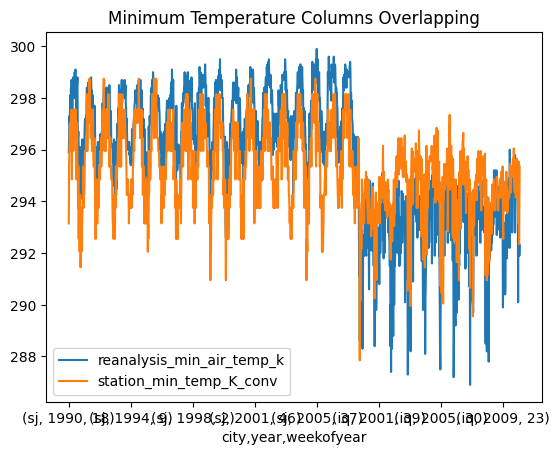

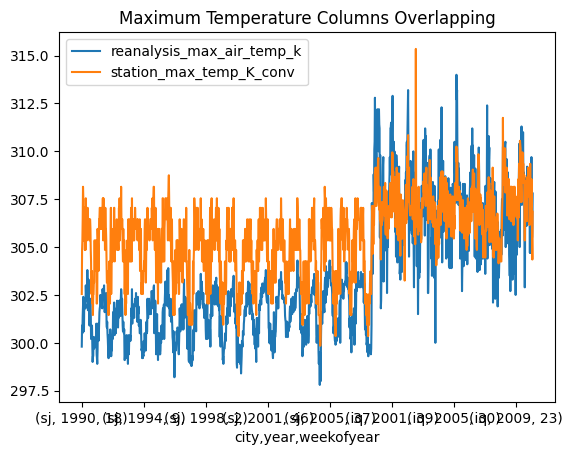

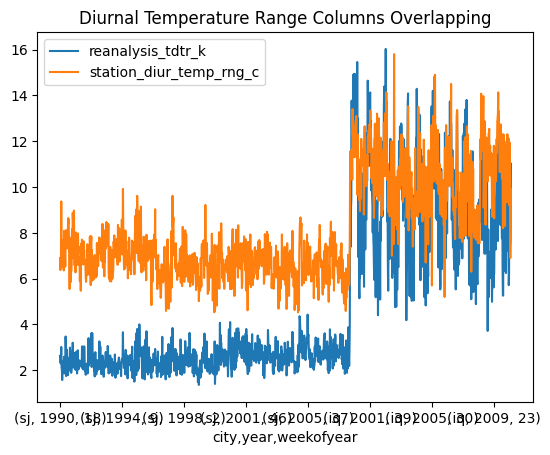

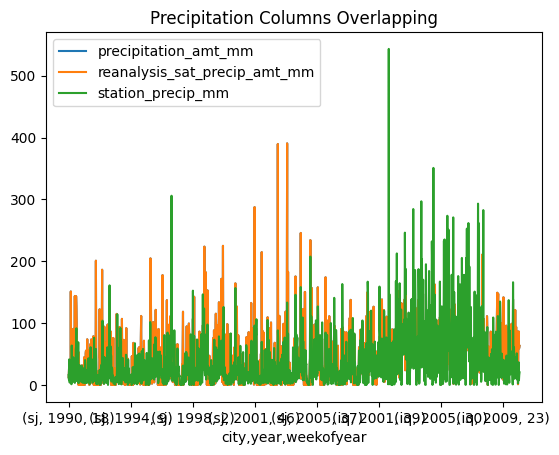

In [125]:
df_features[air_temp].plot(title='Temperature Columns Overlapping', legend=True)
plt.show()

df_features[min_temp].plot(title='Minimum Temperature Columns Overlapping', legend=True)
plt.show()

df_features[max_temp].plot(title='Maximum Temperature Columns Overlapping', legend=True)
plt.show()

df_features[diurn_rg_temp].plot(title='Diurnal Temperature Range Columns Overlapping', legend=True)
plt.show()

df_features[precip_amt].plot(title='Precipitation Columns Overlapping', legend=True)
plt.show()

There seems to be a noticeable difference between the 'reanalysis' temperature values and the 'station' temperature values.  There is currently no basis on which to choose one or the other, so the choice is entirely random at this point, until this work can be revisited for a better selection method.  The 'reanalysis' temperature values will be kept.  Similarly, the 'reanalysis' precipitation will be kept for consistency.

Additionally, the 'reanalysis' precipitation in kg/m2 will be kept as it is a different way to measure precipitation as compared to mm.

The pseudo-redundant features will be dropped below, alongside the time interval variable created earlier for temporary investigative purposes.

# !  
The same columns will have to be dropped from the dengue_features_test dataset if used in the multivariate work (only have features, not labels)

The model won't know what to do with extraneous features.

In [126]:
redundant_features = (['station_avg_temp_c', 'station_avg_temp_K_conv', 'station_max_temp_c', 'station_max_temp_K_conv',
                       'station_min_temp_c', 'station_min_temp_K_conv', 'precipitation_amt_mm', 'station_precip_mm', 
                       'time_interval','station_diur_temp_rng_c'])

for r_feature in redundant_features:
    df_features.drop(r_feature, axis=1, inplace=True)

In [127]:
df_features.head()

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
city year weekofyear                                                           
sj   1990 18              1990-04-30  0.122600  0.103725  0.198483  0.177617   
          19              1990-05-07  0.169900  0.142175  0.162357  0.155486   
          20              1990-05-14  0.032250  0.172967  0.157200  0.170843   
          21              1990-05-21  0.128633  0.245067  0.227557  0.235886   
          22              1990-05-28  0.196200  0.262200  0.251200  0.247340   

                      reanalysis_air_temp_k  reanalysis_avg_temp_k  \
city year weekofyear                                                 
sj   1990 18                     297.572857             297.742857   
          19                     298.211429             298.442857   
          20                     298.781429             298.878571   
          21                     298.987143             299.228571   
          22                     299.518571             299.664286   

                      reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
city year weekofyear                                                           
sj   1990 18                           292.414286                      299.8   
          19                           293.951429                      300.9   
          20                           295.434286                      300.5   
          21                           295.310000                      301.4   
          22                           295.821429                      301.9   

                      reanalysis_min_air_temp_k  \
city year weekofyear                              
sj   1990 18                              295.9   
          19                              296.4   
          20                              297.3   
          21                              297.0   
          22                              297.5   

                      reanalysis_precip_amt_kg_per_m2  \
city year weekofyear                                    
sj   1990 18                                    32.00   
          19                                    17.94   
          20                                    26.10   
          21                                    13.90   
          22                                    12.20   

                      reanalysis_relative_humidity_percent  \
city year weekofyear                                         
sj   1990 18                                     73.365714   
          19                                     77.368571   
          20                                     82.052857   
          21                                     80.337143   
          22                                     80.460000   

                      reanalysis_sat_precip_amt_mm  \
city year weekofyear                                 
sj   1990 18                                 12.42   
          19                                 22.82   
          20                                 34.54   
          21                                 15.36   
          22                                  7.52   

                      reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  
city year weekofyear                                                            
sj   1990 18                                      14.012857           2.628571  
          19                                      15.372857           2.371429  
          20                                      16.848571           2.300000  
          21                                      16.672857           2.428571  
          22                                      17.210000           3.014286

In [128]:
df_features.describe()

week_start_date      ndvi_ne      ndvi_nw      ndvi_se  \
count                           1456  1456.000000  1456.000000  1456.000000   
mean   2001-07-09 16:01:19.120879104     0.131271     0.128068     0.202606   
min              1990-04-30 00:00:00    -0.406250    -0.456100    -0.015533   
25%              1997-04-28 06:00:00     0.039100     0.048250     0.152795   
50%              2002-05-28 00:00:00     0.113900     0.115926     0.195664   
75%              2005-11-26 00:00:00     0.232018     0.213429     0.247461   
max              2010-06-25 00:00:00     0.508357     0.454429     0.538314   
std                              NaN     0.138527     0.119561     0.074409   

           ndvi_sw  reanalysis_air_temp_k  reanalysis_avg_temp_k  \
count  1456.000000            1456.000000            1456.000000   
mean      0.201987             298.697965             299.221483   
min      -0.063457             294.635714             294.892857   
25%       0.144455             297.654643             298.257143   
50%       0.190121             298.646429             299.285714   
75%       0.246775             299.827500             300.207143   
max       0.546017             302.200000             302.928571   
std       0.083592               1.361950               1.262676   

       reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
count                  1456.000000                1456.000000   
mean                    295.245445                 303.419505   
min                     289.642857                 297.800000   
25%                     294.119643                 301.000000   
50%                     295.639286                 302.400000   
75%                     296.460000                 305.500000   
max                     298.450000                 314.000000   
std                       1.527527                   3.233030   

       reanalysis_min_air_temp_k  reanalysis_precip_amt_kg_per_m2  \
count                1456.000000                      1456.000000   
mean                  295.719712                        40.111635   
min                   286.900000                         0.000000   
25%                   293.900000                        13.085000   
50%                   296.200000                        27.245000   
75%                   297.900000                        52.200000   
max                   299.900000                       570.500000   
std                     2.559398                        43.329174   

       reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  \
count                           1456.000000                   1456.000000   
mean                              82.176203                     45.686937   
min                               57.787143                      0.000000   
25%                               77.185714                      9.655000   
50%                               80.301429                     38.235000   
75%                               86.406429                     70.227500   
max                               98.610000                    390.600000   
std                                7.161016                     43.779318   

       reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  
count                            1456.000000        1456.000000  
mean                               16.745565           4.898656  
min                                11.715714           1.357143  
25%                                15.560000           2.328571  
50%                                17.087143           2.857143  
75%                                17.977500           7.617857  
max                                20.461429          16.028571  
std                                 1.542276           3.542340

A case could be made for dropping either reanalysis_air_temp_k or reanalysis_avg_temp_k as their statistics are very similar.  They'll be left in for now.  This could be explored further when an earnest feature selection effort is made for the multivariate EDA and modelling.

### Separating the Data by City
Time to separate the data for the two cities.

In [129]:
# Seperate data for San Juan
sj_df_features = df_features.loc['sj']
sj_df_labels = df_labels.loc['sj']

# Separate data for Iquitos
iq_df_features = df_features.loc['iq']
iq_df_labels = df_labels.loc['iq']

In [130]:
df_labels.head()

total_cases
city year weekofyear             
sj   1990 18                    4
          19                    5
          20                    4
          21                    3
          22                    6

In [131]:
sj_df_labels.head()

total_cases
year weekofyear             
1990 18                    4
     19                    5
     20                    4
     21                    3
     22                    6

## Data Distribution  

Below we'll get a sense of the mean and variance on the dengue cases for each city.  Of course we fully anticipate there's some seasonality to this, so the statistics have to be taken with a grain of salt.

In [132]:
print('San Juan')
print('mean: ', sj_df_labels.mean()[0])
print('var :', sj_df_labels.var()[0])

print('\nIquitos')
print('mean: ', iq_df_labels.mean()[0])
print('var :', iq_df_labels.var()[0])

San Juan
mean:  34.18055555555556
var : 2640.0454396910277

Iquitos
mean:  7.565384615384615
var : 115.89552393656439


C:\Users\ron_d\AppData\Local\Temp\ipykernel_17920\3640038978.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('mean: ', sj_df_labels.mean()[0])
C:\Users\ron_d\AppData\Local\Temp\ipykernel_17920\3640038978.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('var :', sj_df_labels.var()[0])
C:\Users\ron_d\AppData\Local\Temp\ipykernel_17920\3640038978.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('mean: ', iq_

### Histograms and Timeseries Plots

#### Examination of Target Data  
Let's begin with simple timeseries plots of dengue cases for each city.  These give a clue as to whether there are seasonal patterns or a trending effect.  This will lead into a discussion about stationarity and its impacts on classical timeseries modelling.

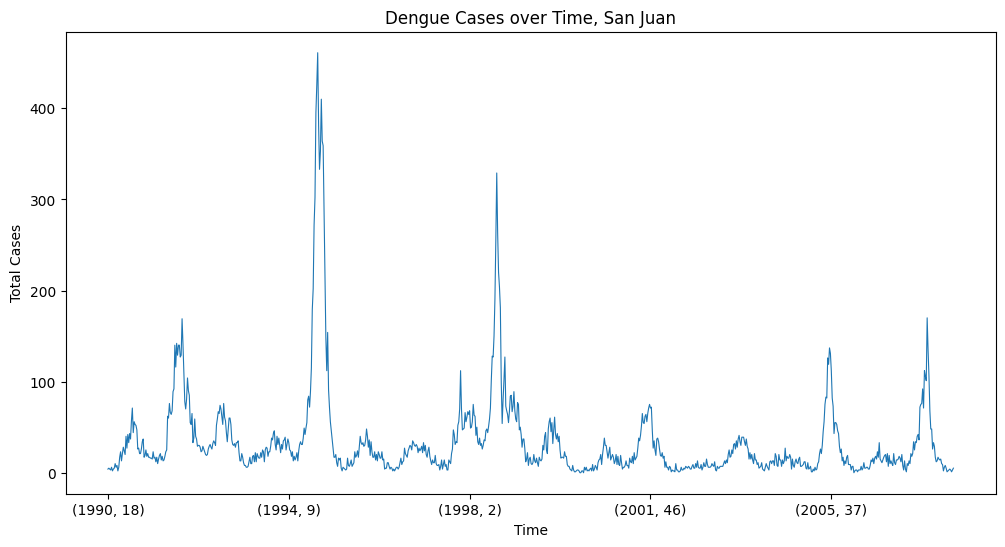

In [133]:
plt.figure(figsize=(12, 6))  # Adjust the figsize according to your preference

# Plot the data
(sj_df_labels
    .total_cases
    .plot
    .line(lw=0.8))

# Set title and labels
plt.title('Dengue Cases over Time, San Juan')
plt.xlabel('Time')
plt.ylabel('Total Cases')

# Show the plot
plt.show()

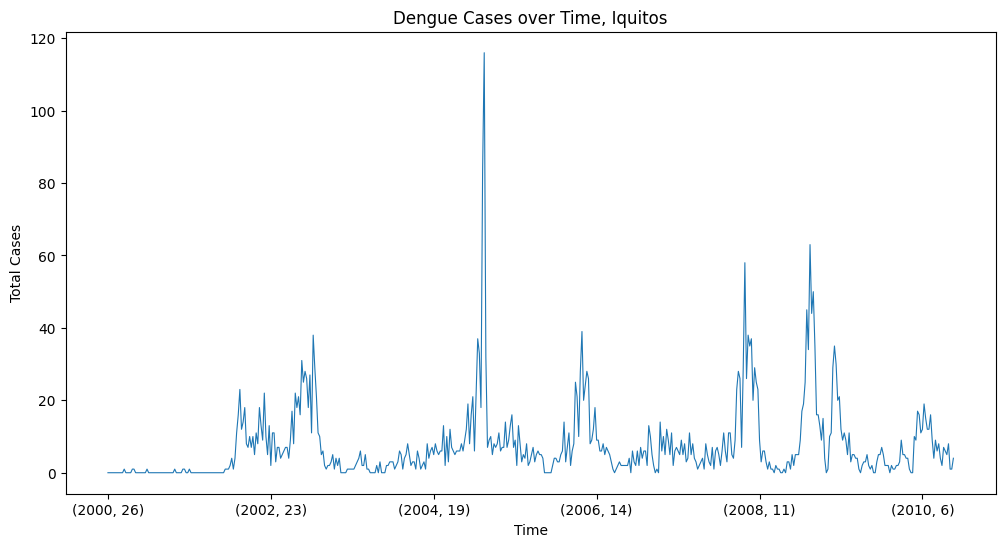

In [134]:
plt.figure(figsize=(12, 6))  # Adjust the figsize according to your preference

# Plot the data
(iq_df_labels
    .total_cases
    .plot
    .line(lw=0.8))

# Set title and labels
plt.title('Dengue Cases over Time, Iquitos')
plt.xlabel('Time')
plt.ylabel('Total Cases')

# Show the plot
plt.show()

There is a conspicuously quiet period at the start of Iquitos' timeseries plot.  It's worth noting.  

There doesn't seem to be a trend, up or down, in the case count for either city over the span of the dataset.  The data would therefore be *trend stationary*.  Of course the scale is set to capture the highest spikes, so any trending happening in the less extreme regions is missed.  The plots are reproduced below with lower y-axis limits to address this.

There may be some seasonality in the spikes seen, but this is a bit more visible and repeatable in the San Juan data, even if some of the spikes differ in size.  That latter observation is presumably explicable by variables impacting cases in any given year, such as higher than usual precipitation or the like.

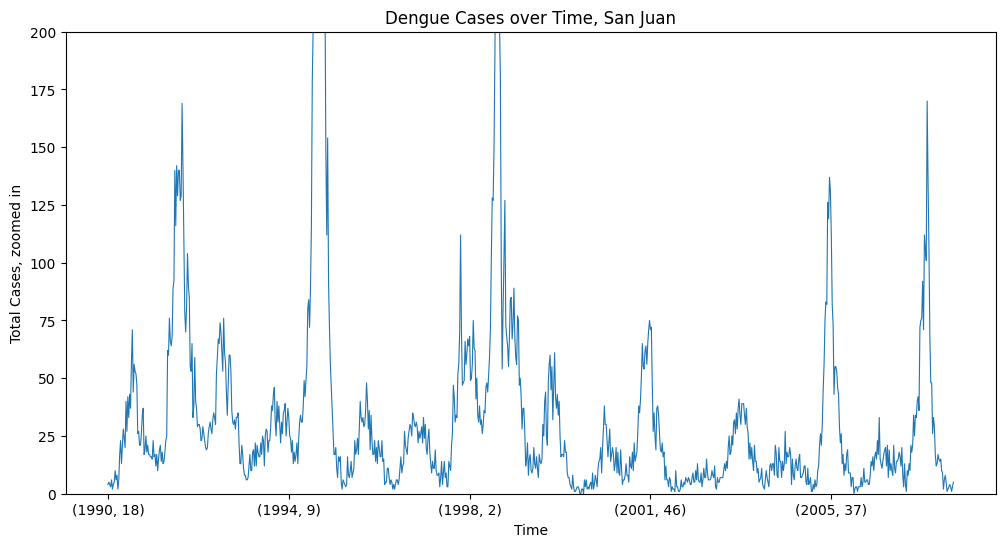

In [135]:
plt.figure(figsize=(12, 6))  # Adjust the figsize according to your preference

# Plot the data
(sj_df_labels
    .total_cases
    .plot
    .line(lw=0.8))

# Set title and labels
plt.title('Dengue Cases over Time, San Juan')
plt.xlabel('Time')
plt.ylabel('Total Cases, zoomed in')
plt.ylim(0, 200)

# Show the plot
plt.show()

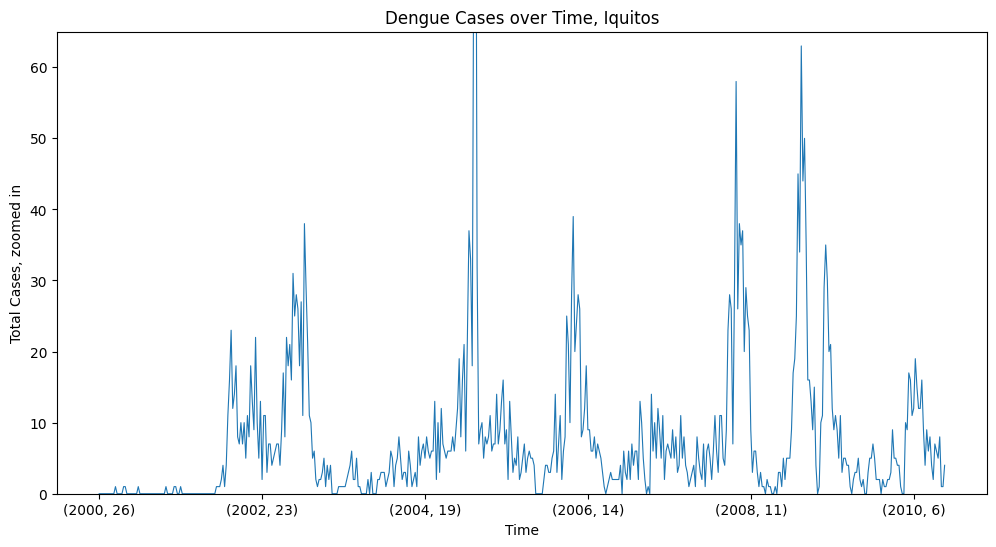

In [136]:
plt.figure(figsize=(12, 6))  # Adjust the figsize according to your preference

# Plot the data
(iq_df_labels
    .total_cases
    .plot
    .line(lw=0.8))

# Set title and labels
plt.title('Dengue Cases over Time, Iquitos')
plt.xlabel('Time')
plt.ylabel('Total Cases, zoomed in')
plt.ylim(0, 65)

# Show the plot
plt.show()

# !  
Timeseries *by year*  
a) Consider plotting for each year, for a given city, on one plot (line plots, but one line per year), OR  
b) A polar seasonal plot: cases are displayed in a circular format around a 'clock' of the year, each year its own line, 1 polar plot per city

Could be informative to identify seasonality.  Looking at all years at once makes it harder to spot a seasonal pattern like spikes during certain months of the year, perhaps following a rainy season.

Let's see the histograms of dengue cases for each city.  

When your mind is used to time invariant data... look at these histograms this way:  for a dataframe tracking people with or without diabetes, for example, you may be interested in a histogram of pregnancies.  In this case, the histogram represents how many rows (patients) had 0, 1, 2, 3, etc... pregnancies.  

For this timeseries, the histogram captures how many rows (snapshots in time) have a dengue count of 0, ... to however many the highest count in the dataset is.  The plot for San Juan below shows that at its very worst, the dengue count for the timespan of this dataset got as high as greater than 400 cases.  But by far, the count that appears the most frequently in this record of cases over time is near zero.  

For Iquitos, the highest count occurs near 120, but again, the most frequent count of cases seen in this record over years is near zero.

The value counts done below each histogram support this observation.  

#### Stationarity  

There may be valuable information in these histograms:  a "squashed" distribution as what's seen below may be a flag that the timeseries are non-stationary.  Stationary data have a mean and variance that do not change with time, and the classical statistical models assume the data is stationary.  If data are found to be non-stationary, they can be made stationary using differencing:  subtracting the last value from the current value.  Other times data may be transformed by some other means to make it "more stationary".  

One way to check for stationarity by some other means than a visual check is to split the data into two (or more) parts, calculate the mean and variance, and see if they seem significantly different.  Performing statistical tests to check for the statistical significance of this difference is said to be difficult due to the serial correlation between the data points.  

Another option is to perform the Augmented Dickey-Fuller test, or the unit root test.  This is performed below the histograms.

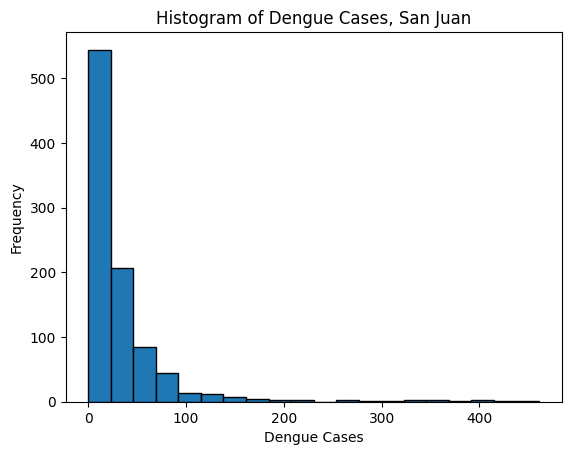

In [137]:
(sj_df_labels
     .total_cases
     .plot
     .hist(bins=20, edgecolor='black'))  # Adjust the number of bins as needed

plt.title('Histogram of Dengue Cases, San Juan')
plt.xlabel('Dengue Cases')
plt.ylabel('Frequency')

plt.show()

In [138]:
unique_counts = sj_df_labels['total_cases'].value_counts()
print(unique_counts)

total_cases
6      35
3      34
7      34
17     33
4      28
       ..
359     1
288     1
221     1
90      1
135     1
Name: count, Length: 134, dtype: int64


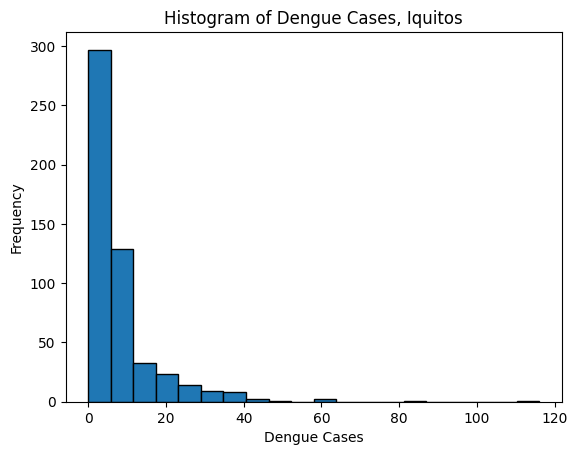

In [139]:
(iq_df_labels
     .total_cases
     .plot
     .hist(bins=20, edgecolor='black'))  # Adjust the number of bins as needed

plt.title('Histogram of Dengue Cases, Iquitos')
plt.xlabel('Dengue Cases')
plt.ylabel('Frequency')

plt.show()

In [140]:
unique_counts = iq_df_labels['total_cases'].value_counts()
print(unique_counts)

total_cases
0      96
1      47
2      46
5      44
6      36
3      36
4      28
7      24
9      21
8      20
11     17
10     11
12      9
16      8
13      7
18      6
21      5
26      4
29      4
25      4
28      4
14      4
35      3
22      3
23      3
19      3
17      3
20      3
15      2
38      2
37      2
31      1
50      1
44      1
63      1
34      1
45      1
32      1
58      1
24      1
39      1
116     1
83      1
33      1
27      1
30      1
Name: count, dtype: int64


Perform the Augmented Dickey-Fuller test (a type of unit root test) for stationarity.

Reference:  https://machinelearningmastery.com/time-series-data-stationary-python/  

In [141]:
result_sj = adfuller(sj_df_labels['total_cases'])
print('ADF Statistic: %f' % result_sj[0])
print('p-value: %f' % result_sj[1])
print('Critical Values:')
for key, value in result_sj[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.650078
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


In [142]:
result_iq = adfuller(iq_df_labels['total_cases'])
print('ADF Statistic: %f' % result_iq[0])
print('p-value: %f' % result_iq[1])
print('Critical Values:')
for key, value in result_iq[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.085429
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


The statistic given by the ADF is said to be interpretable as follows:
* The more negative the statistic, the more likely the data is stationary
* If the statistic is less than the 5% or the 1% value (whichever threshold you select), the data is more likely to be stationary
* If the p-value is less than 0.05, there is support to reject the null hypothesis (H0: the data is non-stationary) and conclude that the data is stationary.

We will continue with the defensible assumption that the data for the target, total_cases, is stationary.

#### Examination of Feature Data  

This may be moved into the eda multivariate notebook.  There's no particular reason to have the feature EDA in here.  It's just an artifact of the "first run" notebook practice of throwing it all in for a reorganization later.

The features are put in a list for easier plotting.

In [143]:
features = df_features.columns[1:]
features

Index(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k'],
      dtype='object')

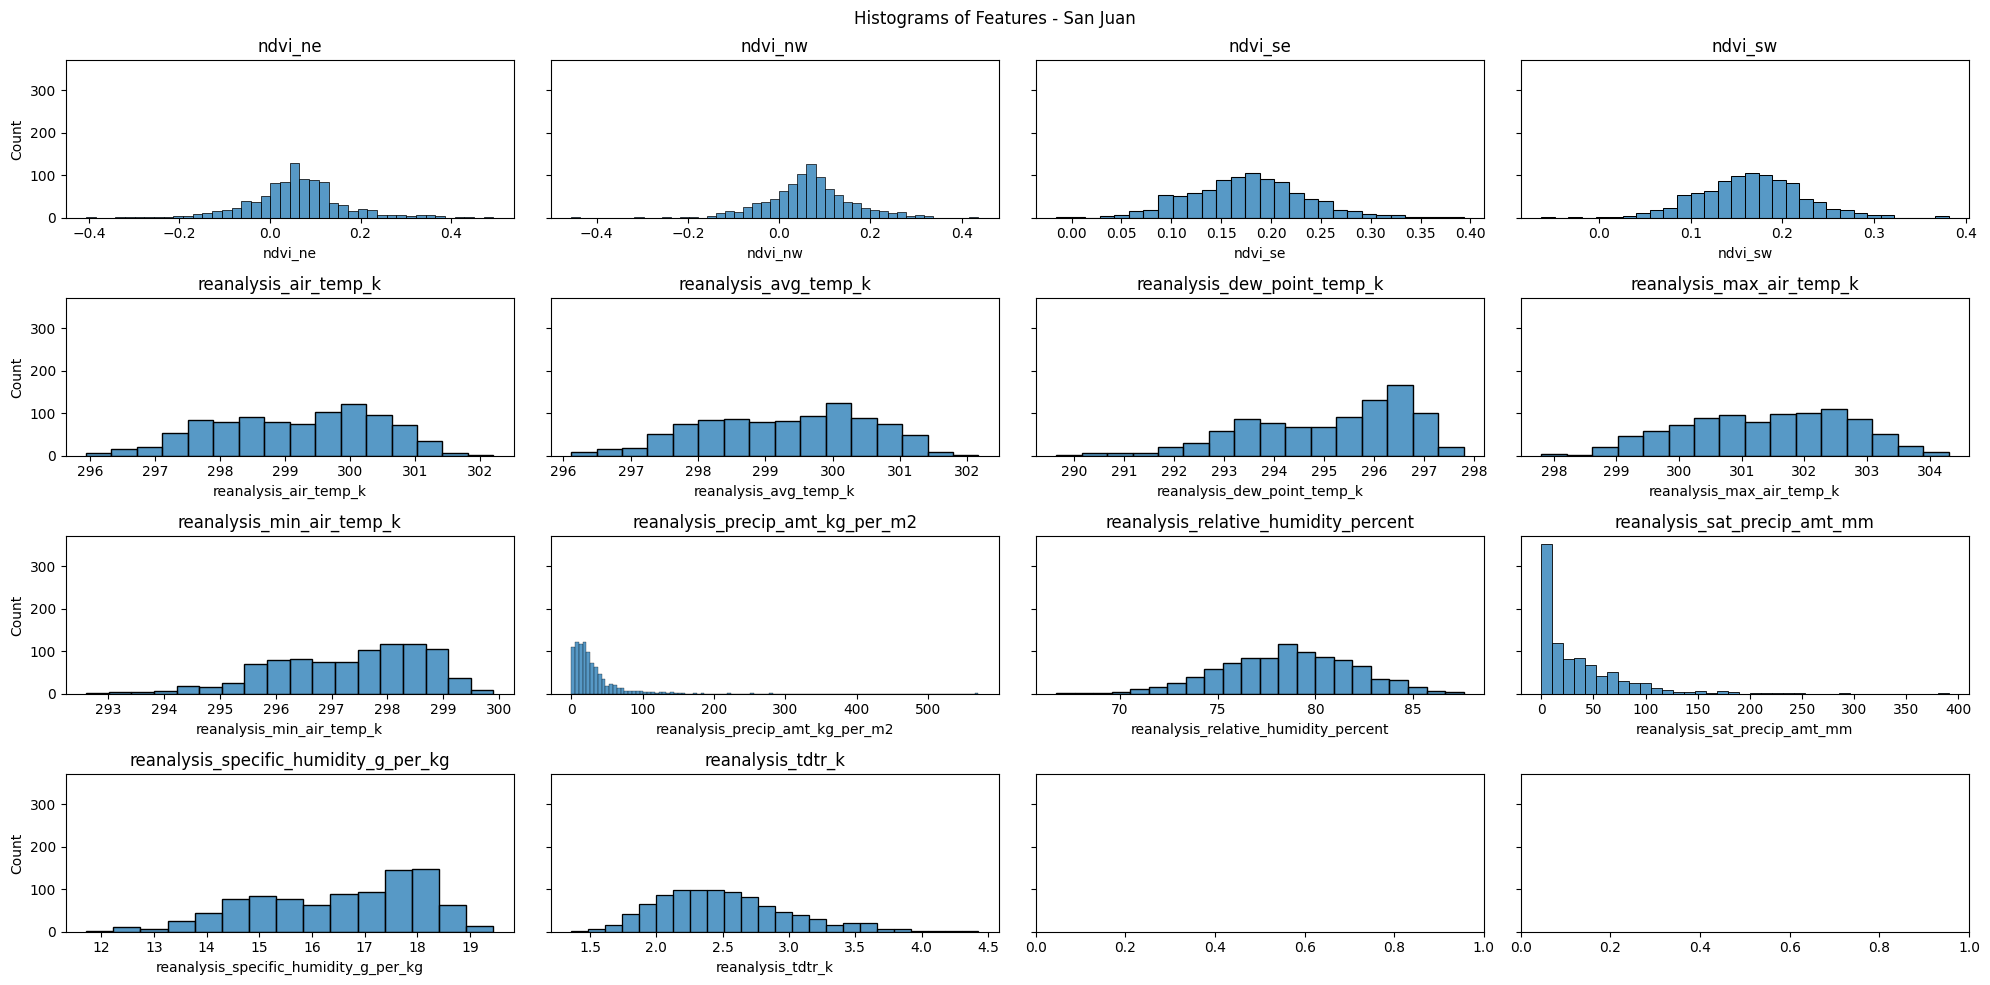

In [144]:
# Feature histograms for San Juan (sj)

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 10), sharey=True)
fig.suptitle('Histograms of Features - San Juan')

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Loop through the features and create boxplots on each subplot
for i, feature in enumerate(features):
    sns.histplot(x=sj_df_features[feature], ax=axes[i])
    axes[i].set_title(feature)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

Now the timeseries for the features for San Juan.  Features are scaled to produce plots with granularity.  Removing scaling produces an inconsistent mix of results even with some tinkering with y_lim.

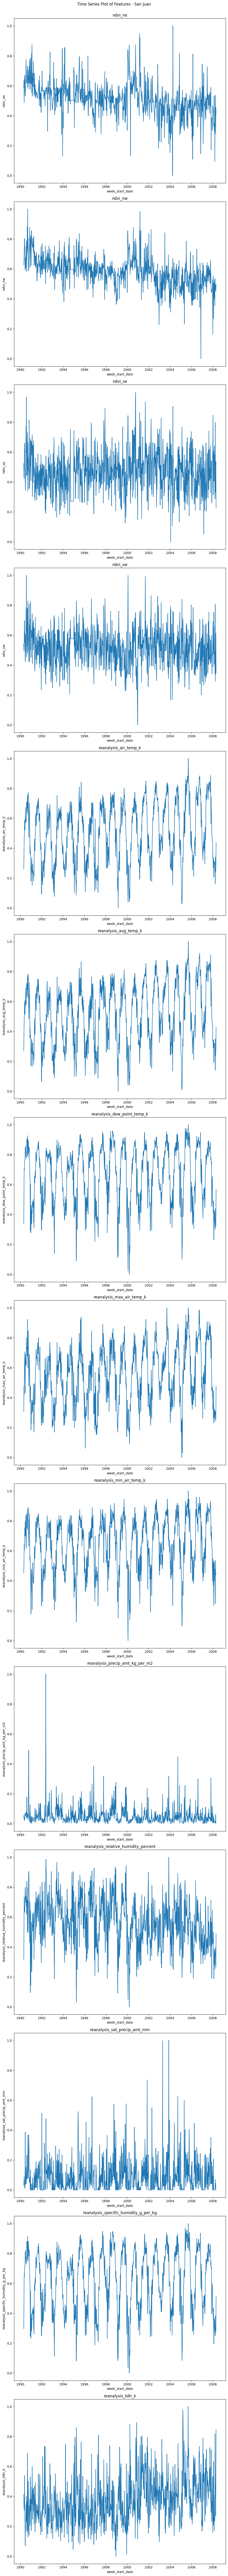

In [145]:
# Calculate the number of rows and columns needed based on the number of features
num_features = len(features)
num_rows = num_features
num_cols = 1

# Create a subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8 * num_rows), sharey=True)
fig.suptitle('Time Series Plot of Features - San Juan', y=1.00)  # Adjust the y position

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
sj_df_normalized = sj_df_features.copy()
sj_df_normalized[features] = scaler.fit_transform(sj_df_features[features])

# Loop through the features and create line plots on each subplot
for i, feature in enumerate(features):
    sns.lineplot(x='week_start_date', y=feature, data=sj_df_normalized, ax=axes[i])
    axes[i].set_title(feature)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


With scaling removed, somehow the plots don't seem to consistently show correctly.

In [183]:
# # Calculate the number of rows and columns needed based on the number of features
# num_features = len(features)
# num_rows = num_features
# num_cols = 1

# # Create a subplot grid
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8 * num_rows), sharey=True)
# fig.suptitle('Time Series Plot of Features - San Juan', y=1.00)  # Adjust the y position

# # Flatten the 2D array of subplots to simplify indexing
# axes = axes.flatten()

# # Loop through the features and create line plots on each subplot
# for i, feature in enumerate(features):
#     sns.lineplot(x='week_start_date', y=feature, data=sj_df_features, ax=axes[i])
#     axes[i].set_title(feature)

#     # Manually set y-axis limits based on the range of each feature
#     feature_min = sj_df_features[feature].min()
#     feature_max = sj_df_features[feature].max()
#     #axes[i].set_ylim(feature_min, feature_max) # some empty plots

#    # Set a minimum range for the y-axis limits
#     min_range = 0.5  # Adjust this value based on your preference
#     if feature_max - feature_min < min_range:
#         axes[i].set_ylim(feature_min - min_range / 2, feature_max + min_range / 2)
#     else:
#         axes[i].set_ylim(feature_min, feature_max)

# # Adjust layout for better visualization
# plt.tight_layout()
# plt.show()


The same plots, now for Iquitos.

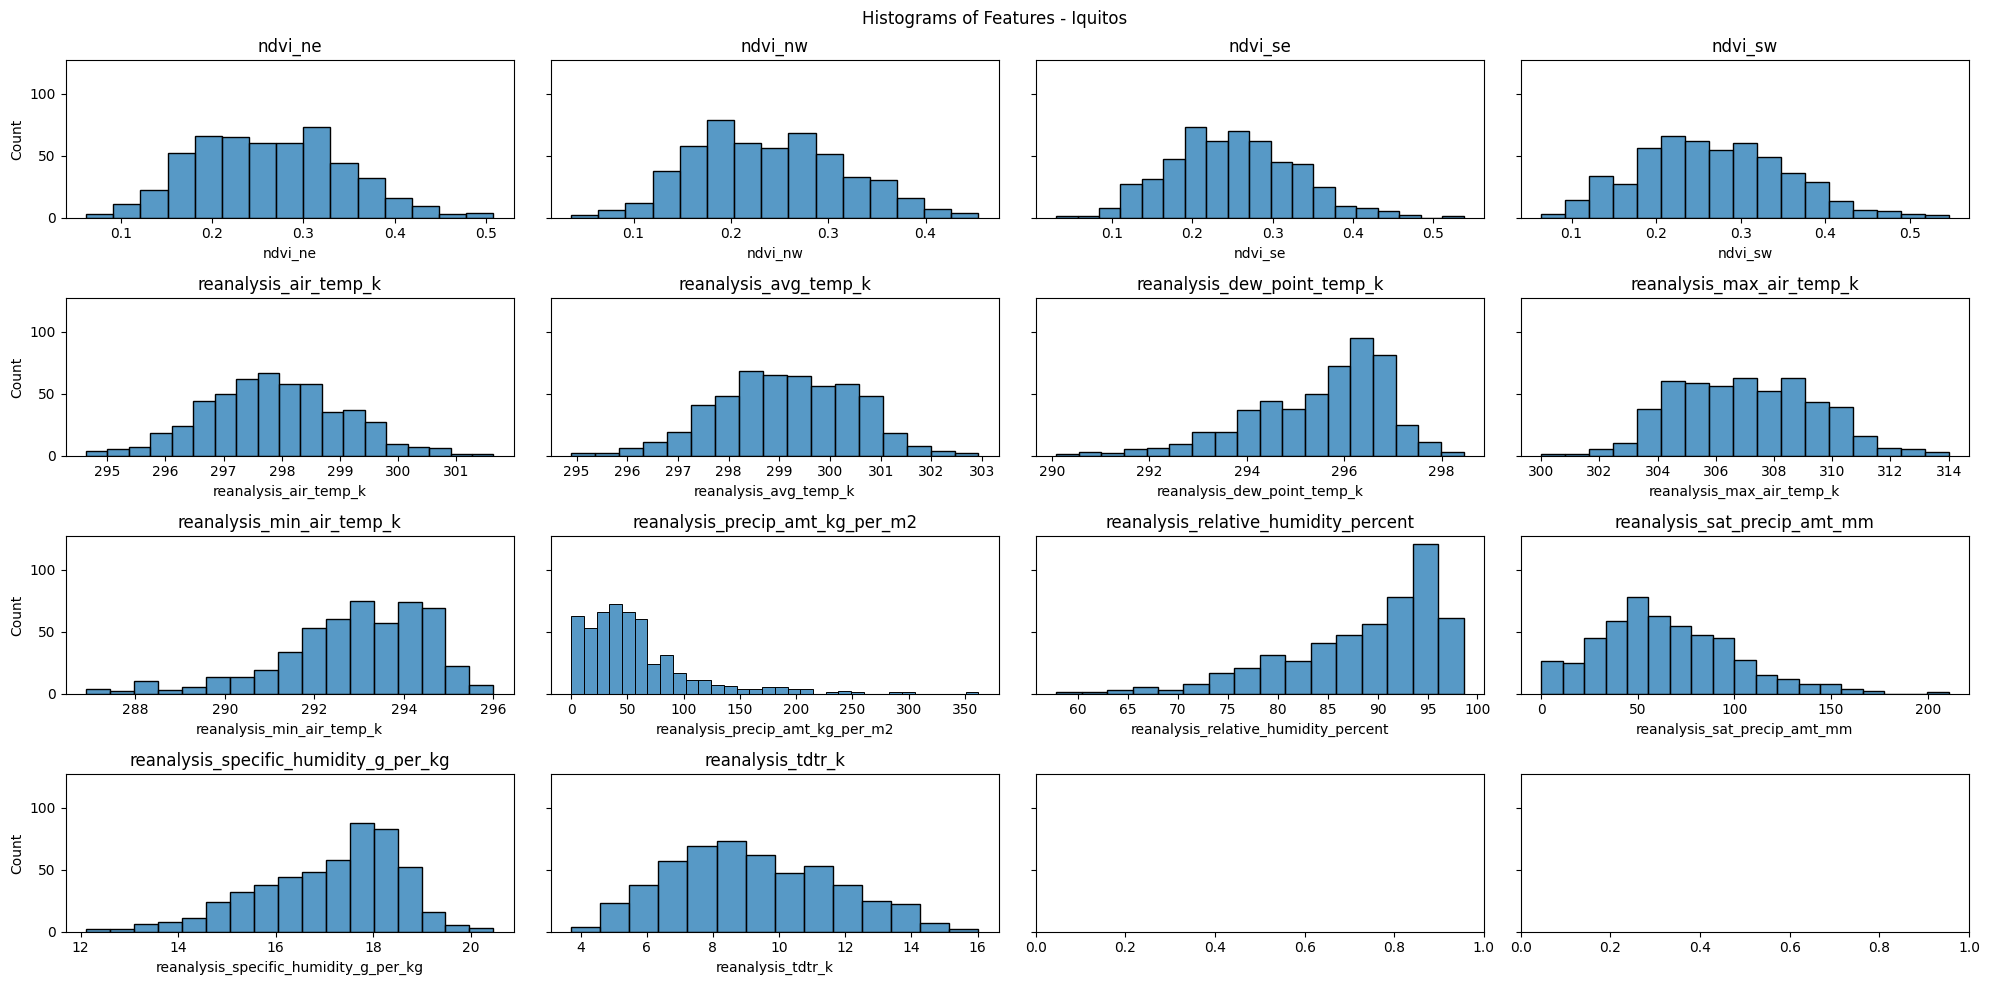

In [147]:
# Feature histograms for Iquitos (iq)

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 10), sharey=True)
fig.suptitle('Histograms of Features - Iquitos')

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Loop through the features and create boxplots on each subplot
for i, feature in enumerate(features):
    sns.histplot(x=iq_df_features[feature], ax=axes[i])
    axes[i].set_title(feature)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

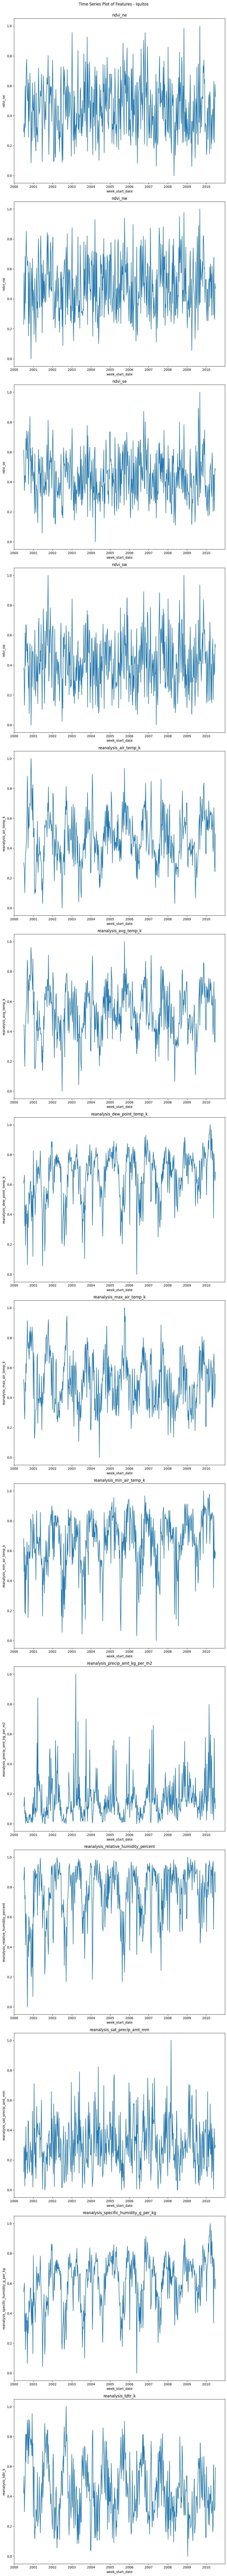

In [148]:
# Calculate the number of rows and columns needed based on the number of features
num_features = len(features)
num_rows = num_features
num_cols = 1

# Create a subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8 * num_rows), sharey=True)
fig.suptitle('Time Series Plot of Features - Iquitos', y=1.00)  # Adjust the y position

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
iq_df_normalized = iq_df_features.copy()
iq_df_normalized[features] = scaler.fit_transform(iq_df_features[features])

# Loop through the features and create line plots on each subplot
for i, feature in enumerate(features):
    sns.lineplot(x='week_start_date', y=feature, data=iq_df_normalized, ax=axes[i])
    axes[i].set_title(feature)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


# !  
Comment here on the feature plots, or remove and do this in the multivariate EDA notebook.

### Autocorrelation: can the target be predicted based on past values of itself?  

`.lag_plot()` lets you see if a given variable has the potential to be predicted based on its past values.  This is only with a lag of 1, and already we see a clear relationship.

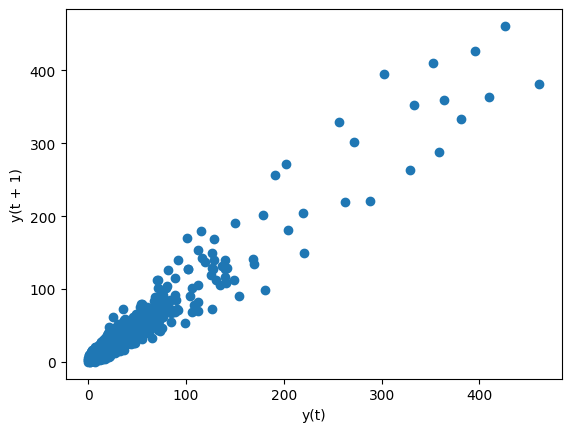

In [149]:
lag_plot(sj_df_labels.total_cases)
plt.show()

The plot below shows the lagged target values on the x-axis and the "present time" target values on the y-axis.  

In other words, for each case count found in the dataset at time t (or the "current row"), this is the y coordinate, its corresponding lagged case count is taken as the other coordinate.  This is done as (x,y) = (case count at lag k, case count at present time), and k takes on values of 1, 2, and 3 to plot below.

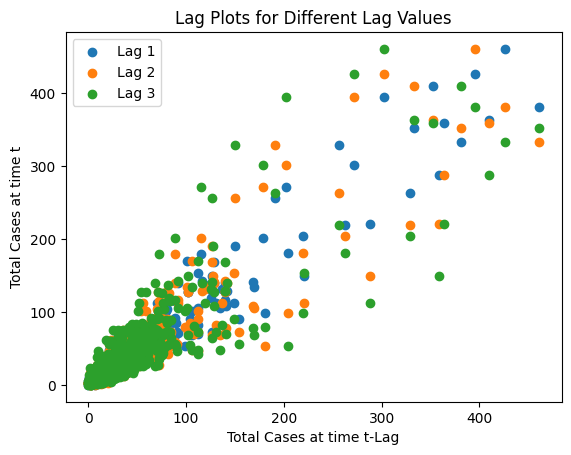

In [150]:
lag_values = [1, 2, 3]  # You can adjust this list to include the lags you are interested in

# Plot the lag plots for each lag
for lag in lag_values:
    plt.scatter(sj_df_labels['total_cases'].shift(lag), sj_df_labels['total_cases'], label=f'Lag {lag}')

plt.xlabel('Total Cases at time t-Lag')
plt.ylabel('Total Cases at time t')
plt.legend()
plt.title('Lag Plots for Different Lag Values')
plt.show()
    

There's a lot of data for 0 to 100 cases, but less as you get to higher case counts.  Additionally, it could be informative to plot the lag plots *per year*, rather than all years thrown in, or per quarter, and this could be Q1 for all years put together, and then Q2 for all years put together, and so on.  It could reveal some seasonality to the case count, which could be expected for a mosquito-borne illness.

We could plot lag plots enough to paper the walls, but ultimately what allows for some automation (pipelining) is producing the correlation values for the target against its lagged self at various lags, and identifying the lag where the maximum correlation value occurs.  

To the question is how many lags back to do want to check for autocorrelation in the target variable, cases?  This is limited to how much data we have.  We'll see the number of rows available for San Juan and Iquitos.

In [151]:
print(f"San Juan has {sj_df_labels.shape[0]} rows of data, each representing a snapshot in time one week after the last row.")
print(f"Iquitos has {iq_df_labels.shape[0]} rows of data, each representing a snapshot in time one week after the last row.")

San Juan has 936 rows of data, each representing a snapshot in time one week after the last row.
Iquitos has 520 rows of data, each representing a snapshot in time one week after the last row.


Each lag, as far as the dataframe is concerned, is simply one row.  In real terms (to us), that's one week.  Given the period of time it takes to hatch mosquitos, and for the infectious bites to occur and for symptoms to appear, one might guess a few weeks, so a few rows.  In one paper, the optimal lag was found to be no more than 12 weeks by meteorological variables, but that will be discussed later as we enter the multivariate part of the analysis.  We may not have to go back that far for an autoregression on targets.  

Reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7537891/#:~:text=These%20values%20were%20selected%20as,weeks%20%5B49%E2%80%9354%5D.

Let's see if we can get autocorrelations on the target variable, cases, for each city up to 12 lags (rows/weeks) behind.  Even if lag 12 is far too much for an autocorrelation, it's a good template for when the time comes to check the optimal lag against the features, where we expect to see a greater 'optimal lag' value.

We'll start with San Juan.

# !  
Consider whether to do the below *after* splitting the dataset.  Otherwise we could be leaking test set data.  However... I don't think anyone will be tremendously surprised to see that a lag of 1 on the case count is the right lag to use, whether I'm using an unsplit dataset or just training data.  Still, for the sake of establishing good practices, this "optimal lag" exercise below should probably be done *after* a splitting of the dataset into train and test sets.

In [152]:
num_lags = 12

# Create lagged columns and concatenate them to the original DataFrame
lagged_columns = [sj_df_labels['total_cases'].shift(i) for i in range(1, num_lags + 1)]
lagged_columns.insert(0, sj_df_labels['total_cases'])  # Insert the original column

# Concatenate the lagged columns
sj_df_labels_lagged = pd.concat(lagged_columns, axis=1)

# Rename the columns
sj_df_labels_lagged.columns = ['t'] + [f't-{i}' for i in range(1, num_lags+1)]
sj_df_labels_lagged.head(13)

t   t-1   t-2   t-3   t-4  t-5  t-6  t-7  t-8  t-9  t-10  \
year weekofyear                                                              
1990 18           4   NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN   NaN   
     19           5   4.0   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN   NaN   
     20           4   5.0   4.0   NaN   NaN  NaN  NaN  NaN  NaN  NaN   NaN   
     21           3   4.0   5.0   4.0   NaN  NaN  NaN  NaN  NaN  NaN   NaN   
     22           6   3.0   4.0   5.0   4.0  NaN  NaN  NaN  NaN  NaN   NaN   
     23           2   6.0   3.0   4.0   5.0  4.0  NaN  NaN  NaN  NaN   NaN   
     24           4   2.0   6.0   3.0   4.0  5.0  4.0  NaN  NaN  NaN   NaN   
     25           5   4.0   2.0   6.0   3.0  4.0  5.0  4.0  NaN  NaN   NaN   
     26          10   5.0   4.0   2.0   6.0  3.0  4.0  5.0  4.0  NaN   NaN   
     27           6  10.0   5.0   4.0   2.0  6.0  3.0  4.0  5.0  4.0   NaN   
     28           8   6.0  10.0   5.0   4.0  2.0  6.0  3.0  4.0  5.0   4.0   
     29           2   8.0   6.0  10.0   5.0  4.0  2.0  6.0  3.0  4.0   5.0   
     30           6   2.0   8.0   6.0  10.0  5.0  4.0  2.0  6.0  3.0   4.0   

                 t-11  t-12  
year weekofyear              
1990 18           NaN   NaN  
     19           NaN   NaN  
     20           NaN   NaN  
     21           NaN   NaN  
     22           NaN   NaN  
     23           NaN   NaN  
     24           NaN   NaN  
     25           NaN   NaN  
     26           NaN   NaN  
     27           NaN   NaN  
     28           NaN   NaN  
     29           4.0   NaN  
     30           5.0   4.0

In [153]:
# use the dataframe to calculate correlations in one shot
correlations_sj = sj_df_labels_lagged.corr()

# Print the correlations
print(correlations_sj)

             t       t-1       t-2       t-3       t-4       t-5       t-6  \
t     1.000000  0.964816  0.920028  0.867856  0.814184  0.755450  0.690118   
t-1   0.964816  1.000000  0.964803  0.919999  0.867808  0.814117  0.755359   
t-2   0.920028  0.964803  1.000000  0.964789  0.919968  0.867757  0.814043   
t-3   0.867856  0.919999  0.964789  1.000000  0.964775  0.919937  0.867702   
t-4   0.814184  0.867808  0.919968  0.964775  1.000000  0.964762  0.919905   
t-5   0.755450  0.814117  0.867757  0.919937  0.964762  1.000000  0.964748   
t-6   0.690118  0.755359  0.814043  0.867702  0.919905  0.964748  1.000000   
t-7   0.622266  0.689999  0.755258  0.813961  0.867647  0.919873  0.964734   
t-8   0.553156  0.622117  0.689867  0.755147  0.813882  0.867594  0.919840   
t-9   0.478586  0.552998  0.621975  0.689745  0.755055  0.813815  0.867545   
t-10  0.409592  0.478421  0.552849  0.621845  0.689643  0.754977  0.813755   
t-11  0.343303  0.409390  0.478232  0.552678  0.621708  0.689534

Now let's visualize this in a heatmap.

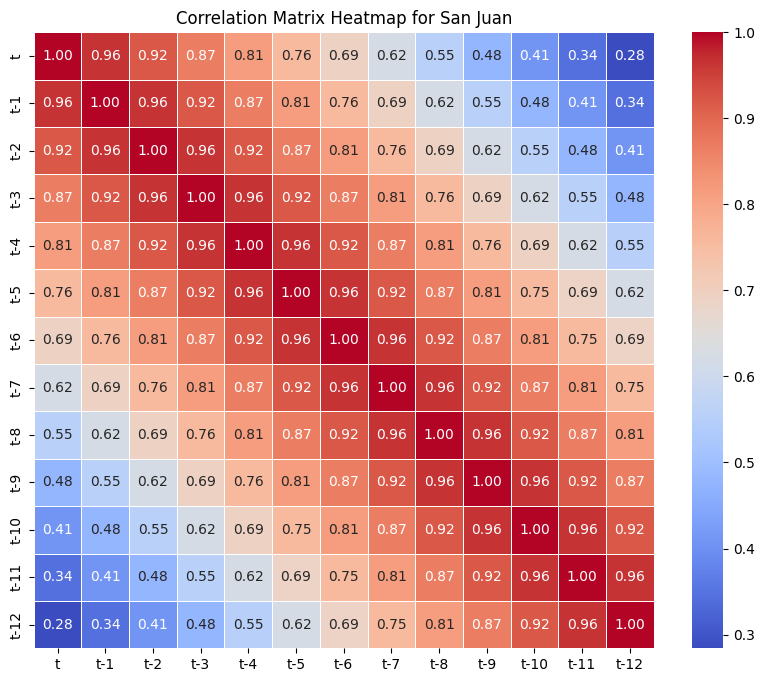

In [154]:
# Assuming 'correlations' is your correlation matrix
# If you haven't run the code to get correlations, uncomment the next line
# correlations = df_lagged.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations_sj, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix Heatmap for San Juan")
plt.show()


We should not be surprised that the case count is most strongly correlated with itself one lag (one week) behind.  As any epidemic will demonstrate, the more infections spread, the faster it "takes off".  This also parallels the general notion that the most recent behaviour in a system is normally a good indicator of its next state, while looking further behind, on its own, may not yield as much insight and proves unpredictable.  This is why we have features to support our predictive efforts in the multivariate part of this project.

So lag = 1 will suffice for autoregression.  

Let's repeat it for Iquitos.

In [155]:
num_lags = 12

# Create lagged columns and concatenate them to the original DataFrame
lagged_columns = [iq_df_labels['total_cases'].shift(i) for i in range(1, num_lags + 1)]
lagged_columns.insert(0, iq_df_labels['total_cases'])  # Insert the original column

# Concatenate the lagged columns
iq_df_labels_lagged = pd.concat(lagged_columns, axis=1)

# Rename the columns
iq_df_labels_lagged.columns = ['t'] + [f't-{i}' for i in range(1, num_lags+1)]
iq_df_labels_lagged.head(13)

t  t-1  t-2  t-3  t-4  t-5  t-6  t-7  t-8  t-9  t-10  t-11  \
year weekofyear                                                               
2000 26          0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   
     27          0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   
     28          0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   
     29          0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   
     30          0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN   NaN   NaN   
     31          0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN   NaN   NaN   
     32          0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN   NaN   NaN   
     33          0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  NaN   NaN   NaN   
     34          0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN   NaN   NaN   
     35          0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   NaN   NaN   
     36          1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   NaN   
     37          0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   
     38          0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   

                 t-12  
year weekofyear        
2000 26           NaN  
     27           NaN  
     28           NaN  
     29           NaN  
     30           NaN  
     31           NaN  
     32           NaN  
     33           NaN  
     34           NaN  
     35           NaN  
     36           NaN  
     37           NaN  
     38           0.0

In [156]:
# use the dataframe to calculate correlations in one shot
correlations_iq = iq_df_labels_lagged.corr()

# Print the correlations
print(correlations_iq)

             t       t-1       t-2       t-3       t-4       t-5       t-6  \
t     1.000000  0.747084  0.584954  0.546021  0.489673  0.365825  0.285352   
t-1   0.747084  1.000000  0.747040  0.584833  0.546105  0.489597  0.365776   
t-2   0.584954  0.747040  1.000000  0.746857  0.585091  0.546049  0.489610   
t-3   0.546021  0.584833  0.746857  1.000000  0.747174  0.585051  0.546084   
t-4   0.489673  0.546105  0.585091  0.747174  1.000000  0.747234  0.585074   
t-5   0.365825  0.489597  0.546049  0.585051  0.747234  1.000000  0.747223   
t-6   0.285352  0.365776  0.489610  0.546084  0.585074  0.747223  1.000000   
t-7   0.262240  0.285348  0.365845  0.489725  0.546090  0.585083  0.747225   
t-8   0.205341  0.261994  0.284904  0.365453  0.489886  0.546017  0.585097   
t-9   0.153588  0.205164  0.261717  0.284637  0.365513  0.489808  0.545990   
t-10  0.118735  0.153629  0.205283  0.261857  0.284636  0.365552  0.489830   
t-11  0.099790  0.118650  0.153508  0.205183  0.261872  0.284586

Now let's visualize this in a heatmap.

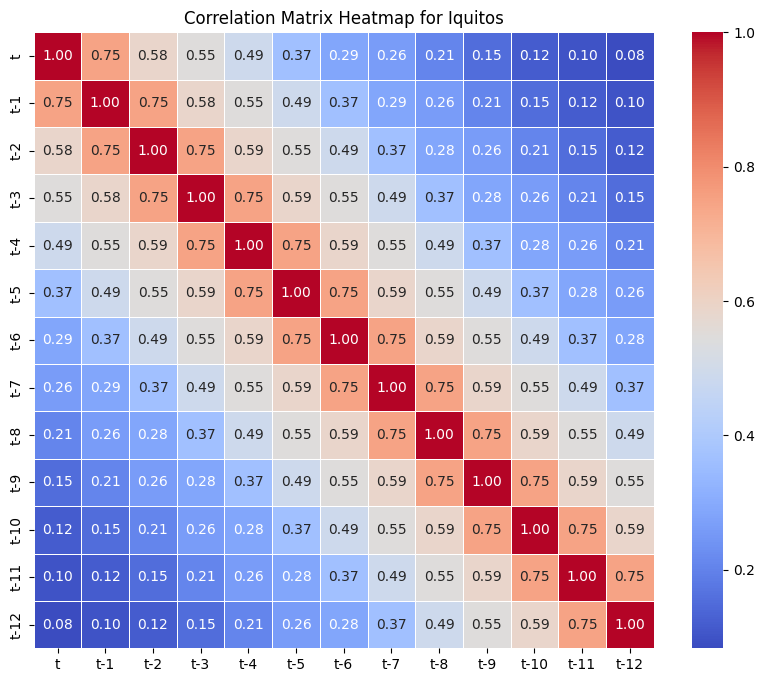

In [157]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlations_iq, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix Heatmap for Iquitos")
plt.show()


Interesting difference, and not subtle.  The autocorrelations for case counts in San Juan are noticeably stronger than they are for Iquitos.  The one lag autocorrelation at 0.75 for Iquitos is still significant, but much weaker than the 0.96 seen for San Juan.  

And because plots are so handy to estimate ideal model inputs, let's produce a couple autocorrelation plots to confirm that lag 1 really is the best for both San Juan and Iquitos' case count.  Both pandas and statsmodels provide this utility.  

Per the below-referenced website, the pandas autocorrelation plot provides confidence intervals:  "The plot also includes solid and dashed lines that indicate the 95% and 99% confidence interval for the correlation values. Correlation values above these lines are more significant than those below the line, providing a threshold or cutoff for selecting more relevant lag values."

Reference: https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/  

We'll start with San Juan using pandas, then statsmodels.

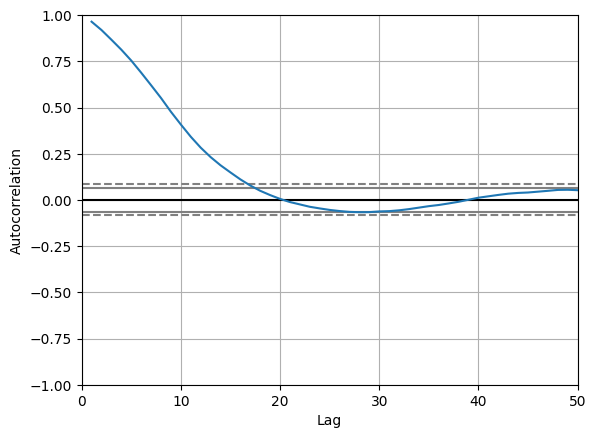

In [185]:
# goes past 800 lags... there's 936 rows of data for San Juan, so that's no surprise.  I've set this limit knowing we're not likely to analyze past 12.  
# It is interesting to change it though.
max_lag=50
autocorrelation_plot(sj_df_labels['total_cases'])
plt.xlim(0, max_lag) 
plt.show()

And now for Statsmodels' take on the autocorrelation plot.  It's comforting to see they produce the same result.

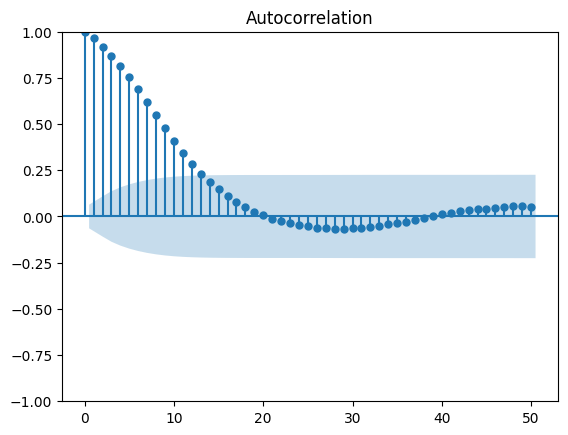

In [159]:
plot_acf(sj_df_labels['total_cases'], lags=50)
plt.show()

And now for Iquitos.

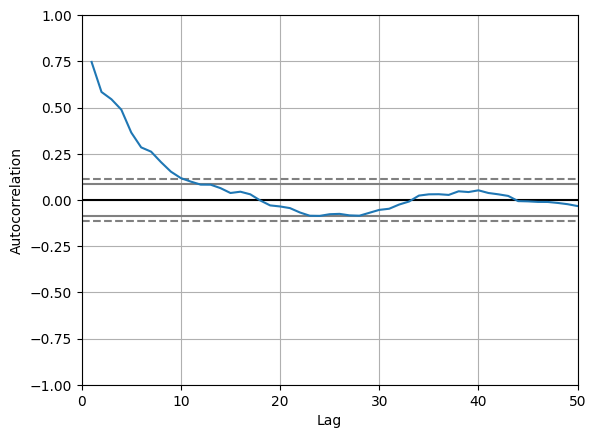

In [187]:
# goes past 500 lags for Iquitos, which is in-line with its row count at 520.
max_lag=50
autocorrelation_plot(iq_df_labels['total_cases'])
plt.xlim(0, max_lag) 
plt.show()

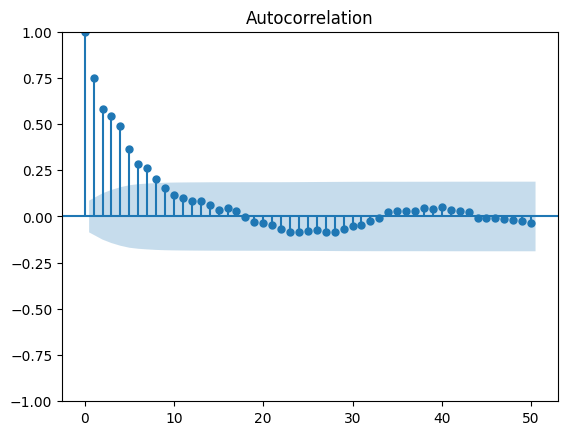

In [161]:
plot_acf(iq_df_labels['total_cases'], lags=50)
plt.show()

A lag of one seems to be quite adequate for San Juan, similarly for Iquitos.  Interestingly, the autocorrelation plots for San Juan are much smoother looking than Iquitos.  

## Split the data into training and test sets  
With this bit of information, we can progress to making an autoregression model from the labels.  For this, we first need to split the data into a training set and a test set.  If a more nuanced method of setting up a train/test split for timeseries is discovered, this will be revisited.  

In [162]:
print(f"Let's make the training set for San Juan {int(sj_df_labels.shape[0] * 0.70)} rows, leaving the last {int(sj_df_labels.shape[0] - (sj_df_labels.shape[0] * 0.70))} rows for testing.")
print(f"Let's make the training set for Iquitos {int(iq_df_labels.shape[0] * 0.70)} rows, leaving the last {int(iq_df_labels.shape[0] - (iq_df_labels.shape[0] * 0.70))} rows for testing.")

Let's make the training set for San Juan 655 rows, leaving the last 280 rows for testing.
Let's make the training set for Iquitos 364 rows, leaving the last 156 rows for testing.


In [163]:
sj_labels_train = sj_df_labels[0:int(sj_df_labels.shape[0] * 0.70)]
sj_labels_train.head()

total_cases
year weekofyear             
1990 18                    4
     19                    5
     20                    4
     21                    3
     22                    6

In [164]:
total_rows = sj_df_labels.shape[0]
train_rows = int(total_rows * 0.70)
test_rows = total_rows - train_rows

print(f"Training set size: {train_rows} rows")
print(f"Testing set size: {test_rows} rows")

# Create the training and testing sets
sj_labels_train = sj_df_labels.iloc[:train_rows]
sj_labels_test = sj_df_labels.iloc[train_rows:]

Training set size: 655 rows
Testing set size: 281 rows


In [165]:
total_rows = iq_df_labels.shape[0]
train_rows = int(total_rows * 0.70)
test_rows = total_rows - train_rows

print(f"Training set size: {train_rows} rows")
print(f"Testing set size: {test_rows} rows")

# Create the training and testing sets
iq_labels_train = iq_df_labels.iloc[:train_rows]
iq_labels_test = iq_df_labels.iloc[train_rows:]

Training set size: 364 rows
Testing set size: 156 rows


In [166]:
sj_labels_train.shape[0] + sj_labels_test.shape[0] == sj_df_labels.shape[0]

True

In [167]:
iq_labels_train.shape[0] + iq_labels_test.shape[0] == iq_df_labels.shape[0]

True

## Baseline model:  Autoregression (AR) from statsmodels  

Autoregression does exactly as it sounds:  it regresses a variable (target) on itself, but itself lagged by some value k.  The lag value chosen, k, is usually informed by a look at autocorrelations as was done above.  For the target variable, total_cases, a lag of one seemed like the best k value to reach for.

Caution:  the AR model expects stationary data, meaning the mean and variance do not change over time, as discussed in the early data exploration.  This requirement is often not met, and there are tests that can be done to verify stationarity.

"When data have a trend, the autocorrelations for small lags tend to be large and positive because observations nearby in time are also nearby in size. So the ACF of trended time series tend to have positive values that slowly decrease as the lags increase.  
When data are seasonal, the autocorrelations will be larger for the seasonal lags (at multiples of the seasonal frequency) than for other lags.  
When data are both trended and seasonal, you see a combination of these effects."  

Reference:  https://otexts.com/fpp2/autocorrelation.html  

"The observations in a stationary time series are not dependent on time.  
Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.  
When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary to be effective."  

Reference: https://machinelearningmastery.com/time-series-data-stationary-python/   

Should the data be found to be non-stationary, the data can be differenced.  Differencing is simply subtracting the last observed value from the current one, or:

y_diff = y(t) - y(t-1)

Sometimes data is log transformed to stabilize the variance.

The autocorrelation plots produced above do show some bigger swings further out if max_lags is set much higher than 50.  With that said, we're going to lean on the Augmented Dickey-Fuller test results to say our data is stationary.

The statsmodels AutoReg() model will be used for this first modelling trial.  
Docs:  https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html 

Note:  an AR model is not necessarily an ideal choice.  It's a starting point, from which one can move onto MA (moving average), or ARMA (autoregressive moving average), ARIMA (autoregressive integrated moving average) models and so on.  The AR model is succinctly described below, and offers the ideal conditions to which it is suited:  no trend or seasonal components.  While the Augmenented Dickey-Fuller test indicated that the total_cases data was stationary, it is resonable to assume there must be some seasonality to the data - and this may indeed be seen in the long-lagged autocorrelation plots - and it would therefore not be adequately fit with an AR model.

"The autoregression (AR) method predicts the subsequent value in a sequence using a linear combination of previous observations. 
The notation for the model involves specifying the order of the model p as a parameter to the AR function, e.g. AR(p). For example, AR(1) is a first-order autoregression model.
The method is best suited for single-variable time series that lack trend and seasonal components."

Reference:  https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

#### Time Problems?  

Apparently AutoReg needs a proper date column to produce predictions.  It produced a model and model parameters, but not predictions, so the lack of a date may be problematic.  

With that said, a quick check on `.head()` for each of the sj_labels_train dataset, with a newly-created synthetic date (1 week interval honoured), and on sj_df_features (not yet split into training & testing), shows the dates don't quite line up as expected. This may require a considerable overhaul (new eda notebook) just for the multivariate effort.  The features and labels dataframes may be merged or concatenated after import so all data have a proper date column, and there may not be a multi-index this time.

For the purposes of using AutoReg, a synthetic week-apart column of dates should do.  

I'm not certain to what extent it matters:  AutoReg is often simply fed an array of values, sometimes made up for a tutorial's sake, and there's no time column fed in.  I'm not convinced this makes a difference other than in making the coding a pain.

In [168]:
sj_labels_train['year'] = sj_labels_train.index.get_level_values('year')
sj_labels_train['weekofyear'] = sj_labels_train.index.get_level_values('weekofyear')

# Create a synthetic date column, starts on Sundays
sj_labels_train['date'] = pd.to_datetime(sj_labels_train[['year', 'weekofyear']].astype(str).agg('-'.join, axis=1) + '-0', format='%Y-%W-%w')

# Set 'date' as the index
sj_labels_train.set_index('date', inplace=True)

C:\Users\ron_d\AppData\Local\Temp\ipykernel_17920\2958607472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sj_labels_train['year'] = sj_labels_train.index.get_level_values('year')
C:\Users\ron_d\AppData\Local\Temp\ipykernel_17920\2958607472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sj_labels_train['weekofyear'] = sj_labels_train.index.get_level_values('weekofyear')
C:\Users\ron_d\AppData\Local\Temp\ipykernel_17920\2958607472.py:5: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [169]:
sj_labels_train.head()

total_cases  year  weekofyear
date                                     
1990-05-06            4  1990          18
1990-05-13            5  1990          19
1990-05-20            4  1990          20
1990-05-27            3  1990          21
1990-06-03            6  1990          22

Could do something similar for test dataset.  To be considered later.

### Fit the AR model to the training labels  

In [170]:
model_sj = AutoReg(sj_labels_train['total_cases'], lags=1) # the lag chosen earlier
model_sj_fit = model_sj.fit()
coef = model_sj_fit.params
print(coef)
print(model_sj_fit.summary())

const             1.325401
total_cases.L1    0.966669
dtype: float64
                            AutoReg Model Results                             
Dep. Variable:            total_cases   No. Observations:                  655
Model:                     AutoReg(1)   Log Likelihood               -2692.718
Method:               Conditional MLE   S.D. of innovations             14.855
Date:                Mon, 05 Feb 2024   AIC                           5391.436
Time:                        15:13:04   BIC                           5404.885
Sample:                             1   HQIC                          5396.651
                                  655                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.3254      0.704      1.883      0.060      -0.054       2.705
total_cases.L1     0.9667      0.010     96.579   

c:\Users\ron_d\anaconda3\envs\lhl_ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ron_d\anaconda3\envs\lhl_ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


The first parameter returned, labelled "const" is the intercept, while the 2nd parameter returned, labelled "total_cases.L1" is the slope applied to each target at time t-1 (lag 1) in order to predict the target at time t:

target(t) = intercept + slope * target(t-1)

Let's see how well it predicts the training labels using this model, and then we'll see about the predictions on the test labels.

### Generate Predictions on the Training Data  

Docs:  https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AutoRegResults.html  

`.predict()` gets you:  In-sample prediction and out-of-sample forecasting  
`.get_prediction()` gets you:  Predictions and prediction intervals  
`.forecast()` gets you:  Out-of-sample forecasts  

Scratching your head yet?  So were others:  https://stats.stackexchange.com/questions/479645/difference-between-forecasting-and-predicting-in-statsmodels-sarimax  

Ok, that's for SARIMAX, but I think the idea translates.

"What the documentation seems to say is that the only difference is that "forecast" is ONLY for predictions at the end of the data (out of sample), whereas "predict" returns predictions from any origin (either from within the sample, or at the end of it). "

I'm grappling with that.  But this sounds interesting:  

`.apply()`:  Apply the fitted parameters to new data unrelated to the original data

We're using the length of the test set so we can take those predictions and compare to test and get some metrics.

In [171]:
start_pt = len(sj_labels_train['total_cases'])
start_pt

655

In [172]:
end_pt = len(sj_labels_train['total_cases'])+len(sj_labels_test)-1
end_pt

935

In [173]:
delta = end_pt - start_pt
delta

280

In [174]:
predictions = model_sj_fit.predict(start=len(sj_labels_train['total_cases']), end=len(sj_labels_train['total_cases'])+len(sj_labels_test)-1, dynamic=False)
for i in range(len(predictions)):
 print('predicted=%f, expected=%f' % (predictions[len(sj_labels_train['total_cases'])+i], sj_labels_test['total_cases'].iloc[i]))
rmse = sqrt(mean_squared_error(sj_labels_test['total_cases'], predictions))
print('Test RMSE: %.3f' % rmse)

predicted=6.158745, expected=5.000000
predicted=7.278867, expected=9.000000
predicted=8.361654, expected=3.000000
predicted=9.408351, expected=6.000000
predicted=10.420160, expected=11.000000
predicted=11.398244, expected=7.000000
predicted=12.343727, expected=7.000000
predicted=13.257696, expected=15.000000
predicted=14.141202, expected=9.000000
predicted=14.995259, expected=6.000000
predicted=15.820849, expected=6.000000
predicted=16.618922, expected=6.000000
predicted=17.390393, expected=7.000000
predicted=18.136151, expected=10.000000
predicted=18.857051, expected=8.000000
predicted=19.553923, expected=7.000000
predicted=20.227568, expected=12.000000
predicted=20.878759, expected=3.000000
predicted=21.508245, expected=2.000000
predicted=22.116749, expected=7.000000
predicted=22.704972, expected=5.000000
predicted=23.273588, expected=5.000000
predicted=23.823251, expected=7.000000
predicted=24.354594, expected=7.000000
predicted=24.868226, expected=7.000000
predicted=25.364738, expe

c:\Users\ron_d\anaconda3\envs\lhl_ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ron_d\anaconda3\envs\lhl_ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ron_d\anaconda3\envs\lhl_ds\lib\site-packages\statsmodels\tsa\deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [175]:
len(predictions)

281

# !  
The predictions plotted in the early '70's is likely because it's interpreting what it thinks is a date column in unix or something.  May have to cast a date (or create a column in datetime datatype) to get predictions to plot properly.

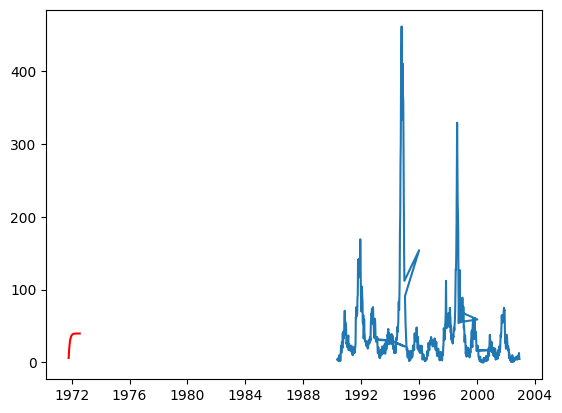

In [176]:
# If I set it to sj_labels_test, I get ValueError: setting an array element with a sequence.
# If I set it to sj_labels_train (not what I actually want), I get predictions set in 1972 (not sure how it's coming up with that).  And I can't compare the test labels with the test predictions, so it's pointless.
#plt.plot(sj_labels_test['total_cases']) # ValueError
plt.plot(sj_labels_train['total_cases']) # not what I want, but it runs so just to avoid errors right now...
plt.plot(predictions, color='red') 
plt.show()

It complains of feeding it something it doesn't like.  Admittedly, when I bring up sj_labels_train['total_cases'], it shows the synthetic date column and the training labels.  When I bring up sj_labels_test['total_cases'] I get that confounded multi-index (grrrrr... causes more trouble than it's worth) and the test labels.  I don't know right now, but I get the sense that's causing some of the trouble.

Let's try something else.

In [177]:
# Not that this is required.  It seems perfectly happy to plot the training values.
plot_train = sj_labels_train['total_cases'].values
plot_train

array([  4,   5,   4,   3,   6,   2,   4,   5,  10,   6,   8,   2,   6,
        17,  23,  13,  21,  28,  24,  20,  40,  27,  42,  33,  43,  37,
        57,  71,  44,  56,  53,  52,  47,  26,  27,  21,  21,  26,  34,
        37,  17,  19,  25,  18,  21,  17,  17,  16,  16,  15,  23,  16,
        17,  12,  17,  10,  15,  19,  21,  14,  18,  13,  14,  18,  23,
        25,  62,  60,  76,  66,  64,  68,  89,  92, 140, 116, 142, 129,
       140, 140, 127, 129, 169, 141, 108,  78,  70,  81, 104,  90,  85,
        55,  53,  65,  33,  38,  59,  40,  37,  29,  30,  30,  28,  23,
        24,  29,  26,  23,  20,  19,  20,  26,  29,  31,  28,  26,  32,
        35,  33,  30,  52,  59,  67,  65,  74,  70,  61,  53,  76,  61,
        57,  44,  34,  47,  60,  60,  53,  36,  31,  30,  32,  28,  33,
        33,  35,  22,  13,  13,  21,  17,  11,   8,   8,   6,   6,   7,
        12,  17,  10,  10,  18,  19,  12,  22,  12,  21,  18,  16,  16,
        22,  17,  25,  23,  12,  25,  28,  27,  18,  23,  23,  2

In [178]:
plot_test = sj_labels_test['total_cases'].values
plot_test
#len(plot_test) # 281 as expected

array([  5,   9,   3,   6,  11,   7,   7,  15,   9,   6,   6,   6,   7,
        10,   8,   7,  12,   3,   2,   7,   5,   5,   7,   7,   7,   7,
        10,  13,  10,  14,  11,  20,  25,  17,  18,  25,  21,  31,  32,
        26,  35,  28,  37,  41,  34,  30,  39,  39,  39,  34,  30,  37,
        29,  26,  15,  22,  15,  20,  14,  10,  21,  14,  14,   9,  11,
         5,   6,   7,  11,   4,   3,   2,   6,  10,   7,   5,   3,  12,
        13,  10,  13,  13,   8,  21,  18,   8,   7,  20,  14,  14,   7,
        14,  10,  13,  27,  13,  18,  16,  16,  20,  17,   4,  15,   8,
         6,  12,  15,  11,  10,  15,  17,   7,   7,   8,   9,  12,  12,
         5,   4,  11,   4,   5,   7,   1,   1,   4,   2,   6,   3,   4,
        10,  12,  21,  26,  21,  30,  45,  56,  75,  83,  82, 126, 119,
       137, 131, 112,  82,  73,  43,  55,  55,  53,  46,  43,  29,  22,
        26,  13,  17,   8,  13,  10,  17,  19,   9,   9,   9,   3,   7,
         7,   0,   2,   3,   3,   1,   3,   3,   3,   7,   3,   

Entered plot_test instead of sj_train_labels['total_cases'], so the x-axis is now indices, not dates.  The blue plot would indicate the indices go out to ~281 (the number of predictions).  Similarly the red plot (preditions) seem to span 281 on the x-axis.

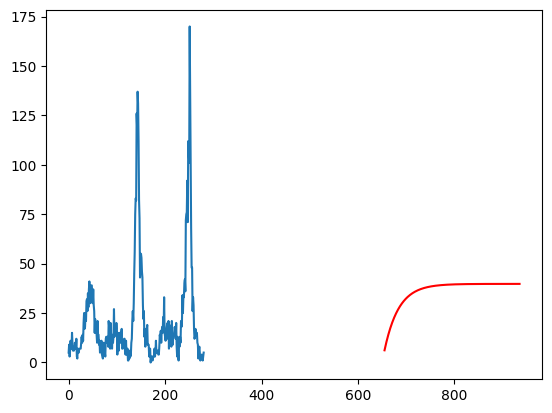

In [179]:
# If I set it to sj_labels_test, I get ValueError: setting an array element with a sequence.
# If I set it to sj_labels_train (not what I actually want), I get predictions set in 1972 (likely a datetime issue)
#plt.plot(sj_labels_test['total_cases']) 
plt.plot(plot_test)
plt.plot(predictions, color='red') 
plt.show()

##### Messing with End param  

Ok, watch this.  I only change the end parameter between the two code blocks below.  I take away the +1 on the end parameter, effectively turning the endpoint from 655 to 654.  

Notice it goes from using some sort of index to using the dates (the synthetic ones) in the case where I get NaNs for the result.  

I'm getting...  
ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(

 

In [180]:
# Now I'm largely leaving start alone and messing with end.
# If I leave start at 652, which was problematic before, and I add 10 to the endpoint, it's perfectly happy to spit out predictions.
# If I set start to 654, I get the same first and only prediction it produced when I set start to 654 and the end to (effectively) 655:
# it predicted 7.12 for the week of Dec 8 (vs 5 in the training set).
predictions3 = model_sj_fit.predict(start=600, end=len(sj_labels_train['total_cases'])+1-1, dynamic=False) # yes I know you'd tack on the len(test_set)
predictions3

c:\Users\ron_d\anaconda3\envs\lhl_ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ron_d\anaconda3\envs\lhl_ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ron_d\anaconda3\envs\lhl_ds\lib\site-packages\statsmodels\tsa\deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


600    73.825558
601    69.958883
602    70.925552
603    46.758833
604    27.425458
605    35.158808
606    25.492120
607    19.692107
608    37.092145
609    38.058814
610    34.192139
611    26.458789
612    19.692107
613    18.725439
614    22.592114
615    16.792101
616    18.725439
617     7.125413
618    12.925426
619     7.125413
620     7.125413
621     4.225407
622     8.092082
623     7.125413
624     2.292070
625     4.225407
626     3.258738
627     3.258738
628     2.292070
629    10.992089
630     4.225407
631     4.225407
632     2.292070
633     2.292070
634     3.258738
635     7.125413
636     4.225407
637     4.225407
638     6.158745
639     5.192076
640     8.092082
641     7.125413
642     6.158745
643     8.092082
644     7.125413
645     5.192076
646     5.192076
647     8.092082
648    10.025420
649     6.158745
650     6.158745
651    10.992089
652     7.125413
653    13.892095
654     7.125413
655     6.158745
dtype: float64

In [181]:
predictions4 = model_sj_fit.predict(start=600, end=len(sj_labels_train['total_cases'])-1, dynamic=False)
predictions4

date
2001-11-18   NaN
2001-11-25   NaN
2001-12-02   NaN
2001-12-09   NaN
2001-12-16   NaN
2001-12-23   NaN
2001-12-30   NaN
2002-01-13   NaN
2002-01-20   NaN
2002-01-27   NaN
2002-02-03   NaN
2002-02-10   NaN
2002-02-17   NaN
2002-02-24   NaN
2002-03-03   NaN
2002-03-10   NaN
2002-03-17   NaN
2002-03-24   NaN
2002-03-31   NaN
2002-04-07   NaN
2002-04-14   NaN
2002-04-21   NaN
2002-04-28   NaN
2002-05-05   NaN
2002-05-12   NaN
2002-05-19   NaN
2002-05-26   NaN
2002-06-02   NaN
2002-06-09   NaN
2002-06-16   NaN
2002-06-23   NaN
2002-06-30   NaN
2002-07-07   NaN
2002-07-14   NaN
2002-07-21   NaN
2002-07-28   NaN
2002-08-04   NaN
2002-08-11   NaN
2002-08-18   NaN
2002-08-25   NaN
2002-09-01   NaN
2002-09-08   NaN
2002-09-15   NaN
2002-09-22   NaN
2002-09-29   NaN
2002-10-06   NaN
2002-10-13   NaN
2002-10-20   NaN
2002-10-27   NaN
2002-11-03   NaN
2002-11-10   NaN
2002-11-17   NaN
2002-11-24   NaN
2002-12-01   NaN
2002-12-08   NaN
dtype: float64

All this fun above was done for San Juan.  If some of the hiccups can be sorted out, it will be repeated for Iquitos.  It would be nice to first clean up the San Juan effort.  I may yet do a considerable overhaul in how the datasets were hauled in as I feel the lack of a clear datetime column posed some problems and the multiindex just made things difficult.  With that said, some of the code above was tweaked *because* of the multi-index, so it's not just a variable renaming effort if I change the import and dataframe creation, but it may be a re-code of some stuff.  I have to weigh the benefits vs drawbacks.

Additionally, if there's time, an ARIMA model could be attempted.  Right now I'm prioritizing creating a much-improved eda notebook for the multivariate prep, and trying at least an early multivariate timeseries model like RF or XGB.  If I don't at least try those, I suspect I won't get to LSTM.

__________________________________________________
This is how he produces a 7 day forecast using AutoReg.  See how it differs from the code that follows.

In [ ]:
# # create and evaluate a static autoregressive model
# from pandas import read_csv
# from matplotlib import pyplot
# from statsmodels.tsa.ar_model import AutoReg
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# # load dataset
# series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# # split dataset
# X = series.values  # Check the format on this.  I may need to use reshape to get my values arrayed like he has them (multiple rows)
# train, test = X[1:len(X)-7], X[len(X)-7:]
# # train autoregression
# model = AutoReg(train, lags=29)
# model_fit = model.fit()
# print('Coefficients: %s' % model_fit.params)
# # make predictions
# predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# for i in range(len(predictions)):
# 	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
# rmse = sqrt(mean_squared_error(test, predictions))
# print('Test RMSE: %.3f' % rmse)
# # plot results
# pyplot.plot(test)
# pyplot.plot(predictions, color='red')
# pyplot.show()

______________________________
The code directly below is taken from https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/  

(He trained a model with a lag=29)

"The statsmodels API does not make it easy to update the model as new observations become available.

One way would be to re-train the AutoReg model each day as new observations become available, and that may be a valid approach, if not computationally expensive.

An alternative would be to use the learned coefficients and manually make predictions. This requires that the history of 29 prior observations be kept and that the coefficients be retrieved from the model and used in the regression equation to come up with new forecasts.

The coefficients are provided in an array with the intercept term followed by the coefficients for each lag variable starting at t-1 to t-n. We simply need to use them in the right order on the history of observations, as follows:

yhat = b0 + b1*X1 + b2*X2 ... bn*Xn"

In [ ]:
# train autoregression

#window = 1 # the "run-up" required for your model to produce a prediction per the number of lags used for your AR model, per the autocorrelation findings.  I used 1 lag.
##model = AutoReg(train, lags=1)
##model_fit = model.fit()
##coef = model_fit.params

# walk forward over time steps in test

#history = train[len(train)-window:]
#history = [history[i] for i in range(len(history))]
#predictions = list()
#for t in range(len(test)):
# length = len(history)
# lag = [history[i] for i in range(length-window,length)]
# yhat = coef[0]
# for d in range(window):
# yhat += coef[d+1] * lag[window-d-1]
# obs = test[t]
# predictions.append(yhat)
# history.append(obs)
# print('predicted=%f, expected=%f' % (yhat, obs))

______________________________
# To Do/Should do? List  

##### At the multivariate part  
Consider:
* If differencing needs to occur on certain features, do you do this *before* examining correlation (and lagged correlation) plots of those features against the target?

Pairplots with everyone at time t is a start, but it could then be done for varying lags.  Of course the "right" lag that may show a relationship between cases & features could be different from one pair to another.  This is gravy, and may not be necessary, as it should only reinforce what's found in the other preliminary work.